<div class="alert alert-block alert-success">

# **1.** **Setup**

<div>

In [209]:
from utils import *

In [2]:
# Set random seeds for reproducibility
tf.random.set_seed(221)
random.seed(221)
np.random.seed(221)
tf.random.set_seed(221)

## **1.1** Datasets

In [3]:
# Load the train/val split data
with open('train_val_split.pkl', 'rb') as f:
    data = pickle.load(f)

# Store the data in variables
x_train = data['x_train']
x_val = data['x_val']
y_train = data['y_train']
y_val = data['y_val']

In [4]:
# For EXTRA

# Load the train/val split data without preprocessing
with open('train_val_split_no_preproc.pkl', 'rb') as f:
    data_no_preproc = pickle.load(f)

# Convert DataFrames to list
train_texts = data_no_preproc['x_train'].tolist()
val_texts = data_no_preproc['x_val'].tolist()

# Convert Series to list
train_labels = data_no_preproc['y_train'].tolist()
val_labels = data_no_preproc['y_val'].tolist()

## **1.2** Parameters

In [5]:
# ------- Parameters ------- 
# Glove
emb_size = 50 # start small than increase to find the best value

# TF-IDF
max_df = 0.8 # we are removing terms that appear in >80% of tweets

# Word2Vec
window = 2         # context window size
min_count = 1      # minimum word frequency to include

# KNN
n_neighbors = 10
metric = 'cosine'
weights = 'distance'

# Naive Bayes
alpha = 1

# Random Forest
n_estimators = 200
criterion = 'gini'
max_depth = 20 # to control overfitting
min_samples_split = 10 # to avoid split on very small groups
min_samples_leaf = 3 # to avoid very specific rules
max_features = 'sqrt'
class_weight = 'balanced'

# Logistic Regression
penalty = 'elasticnet'
solver = 'saga'
l1_ratio = 0.5
C = 0.15
class_weight = 'balanced'
max_iter=300
multi_class='multinomial'

# XGBoost
objective='multi:softmax'
num_class=3
eval_metric='mlogloss'
use_label_encoder=False
learning_rate = 0.05 # for better convergence
max_depth_xgboost = 6
n_estimators_xgboost = 300
subsample = 0.8 # 80% of rows per tree to reduce overfitting
colsample_bytree = 1
scale_pos_weight = 1

# LSTM
batch_size=16
epochs=10
sg=1
learning_rate_lstm=0.001
optimizer=Adam(learning_rate=learning_rate_lstm)
loss='categorical_crossentropy'
metrics=['categorical_accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc', multi_label=True)]
units=64
dropout=0.3

## **1.3** General

In [6]:
corpus = x_train['text']

#get list with lenghts of sentences
train_len = []
for i in corpus:
    train_len.append(len(i))

vector_size = max(train_len)

metrics_df = []

In [7]:
tokenized_train = [word_tokenize(tweet.lower()) for tweet in x_train['text']]
max_seq_len = max(len(tokens) for tokens in tokenized_train)

## **1.4** Models

### Glove

In [8]:
model_name = 'glove-twitter'
glove_model = gensim.downloader.load(f'{model_name}-{emb_size}')

### Text Embeddings 3 Small

In [9]:
# EXTRA

# Load variables from .env into environment
load_dotenv()

# Print environment variable
print("AZURE_OPENAI_ENDPOINT:", os.getenv("AZURE_OPENAI_ENDPOINT"))

# Initialize Azure OpenAI client
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_KEY"),
    api_version="2024-02-01",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT")
)

# Define embedding model
model = "text-embedding-3-small"

AZURE_OPENAI_ENDPOINT: https://novaimsplayground.openai.azure.com/


In [10]:
# Define embedding model text embedding
model_te3s = "text-embedding-3-small"

### Roberta

In [11]:
# Load the pre-trained model and tokenizer for roberta
model_name = "cardiffnlp/twitter-roberta-base"
tokenizer_roberta = AutoTokenizer.from_pretrained(model_name)
model_roberta = AutoModel.from_pretrained(model_name)

### LSTM

In [12]:
input_ = Input(shape=(max_seq_len, vector_size))

x = Masking(mask_value=0.0)(input_)
x = Bidirectional(LSTM(units=units, return_sequences=False, dropout=dropout, recurrent_dropout=dropout))(x)
x = Dropout(dropout)(x)
output = Dense(num_class, activation='softmax')(x)

<div class="alert alert-block alert-success">

# **2.** **KNN**

<div>

## **2.1** Bag of Words

### **2.1.1** Unigrams

In [13]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = 'distance')

# each term is marked as present or not per document - good for short text
X_bow_unigrams, y_train_pred_bow_unigrams, y_val_pred_bow_unigrams, bow_unigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, model=modelknn)

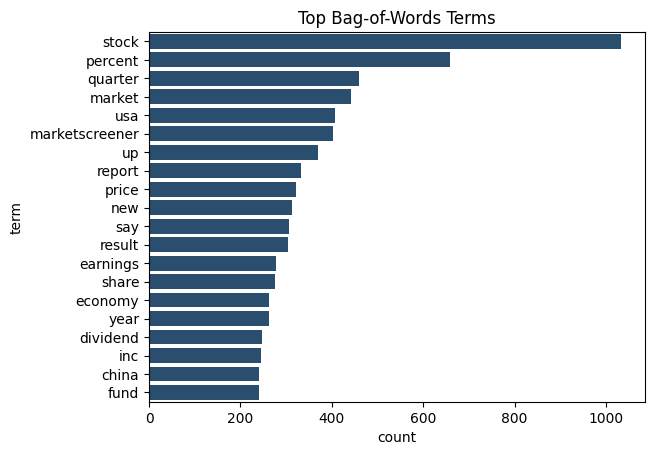

In [14]:
clean_bow_sum = np.array(X_bow_unigrams.sum(axis=0)).flatten()
clean_terms = bow_unigrams.get_feature_names_out()
clean_top = pd.DataFrame({'term': clean_terms, 'count': clean_bow_sum}).sort_values(by='count', ascending=False).head(20)

sns.barplot(data=clean_top, x='count', y='term', color='#1f4e79')
plt.title("Top Bag-of-Words Terms")
plt.show()

In [15]:
title = "KNN BoW Unigrams"

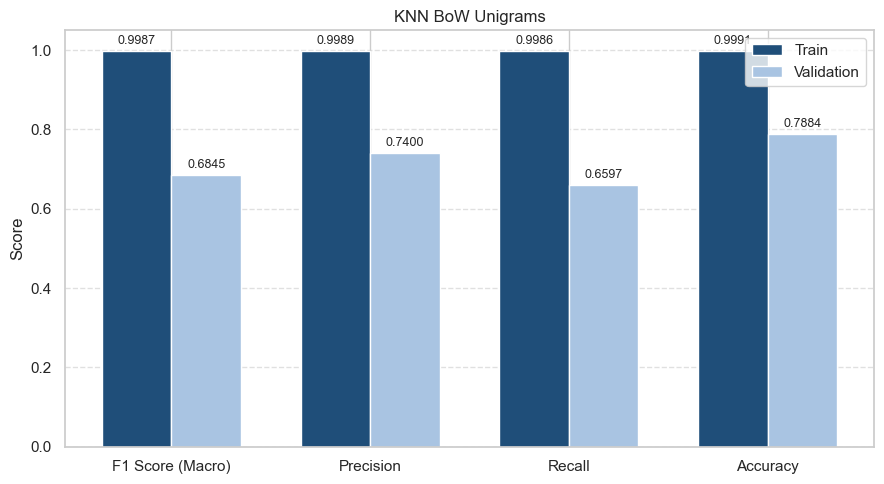

In [16]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_bow_unigrams, y_val, y_val_pred_bow_unigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_bow_unigrams, y_val, y_val_pred_bow_unigrams, title=title)

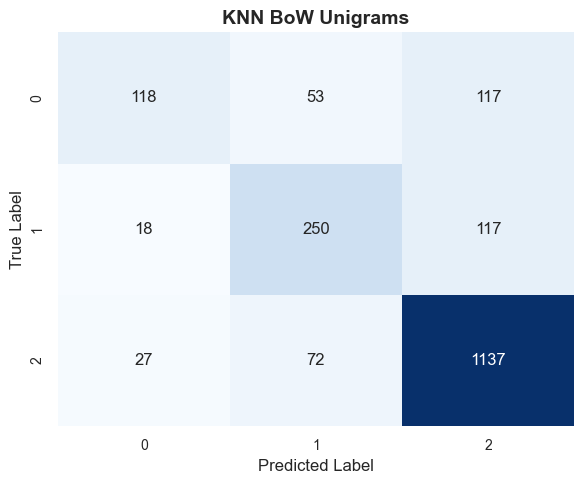

In [17]:
plot_confusion_matrix(y_val, y_val_pred_bow_unigrams, title=title, labels=[0, 1, 2], cmap="Blues")

### **2.1.2** Unigrams + Bigrams

In [18]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = 'distance')

X_bow_bigrams, y_train_pred_bow_bigrams, y_val_pred_bow_bigrams, bow_bigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, model=modelknn, ngram_range=(1,2), oversampling_function=oversample)

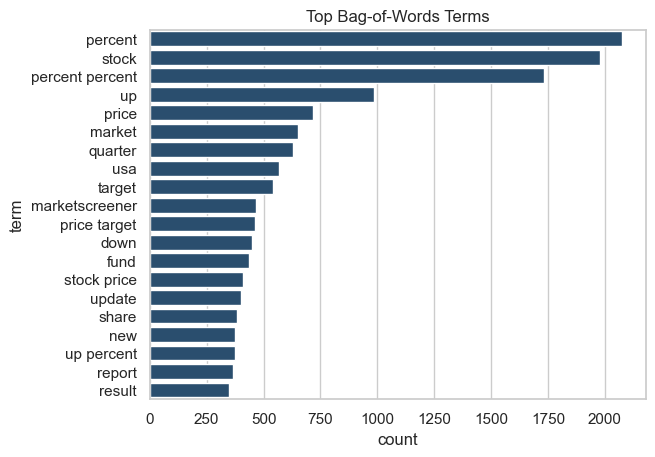

In [19]:
clean_bow_sum = np.array(X_bow_bigrams.sum(axis=0)).flatten()
clean_terms = bow_bigrams.get_feature_names_out()
clean_top = pd.DataFrame({'term': clean_terms, 'count': clean_bow_sum}).sort_values(by='count', ascending=False).head(20)

sns.barplot(data=clean_top, x='count', y='term', color='#1f4e79')
plt.title("Top Bag-of-Words Terms")
plt.show()

In [20]:
title = "KNN BoW Bigrams"

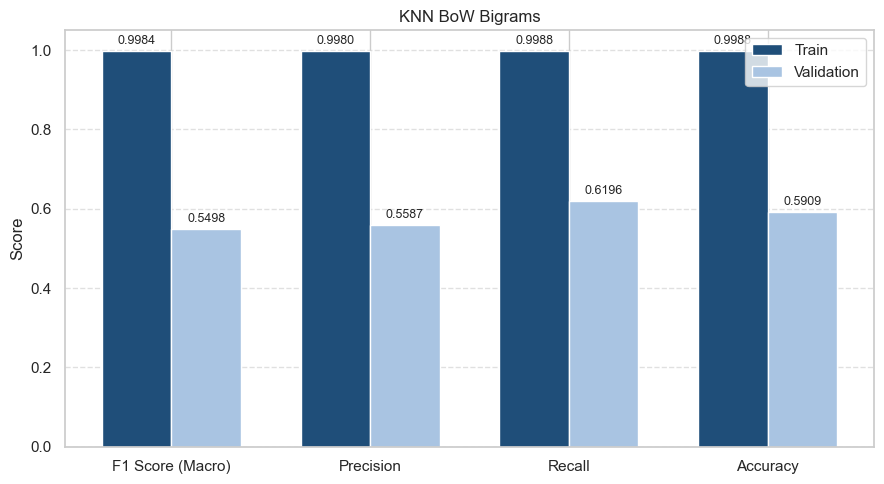

In [21]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_bow_bigrams, y_val, y_val_pred_bow_bigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_bow_bigrams, y_val, y_val_pred_bow_bigrams, title=title)

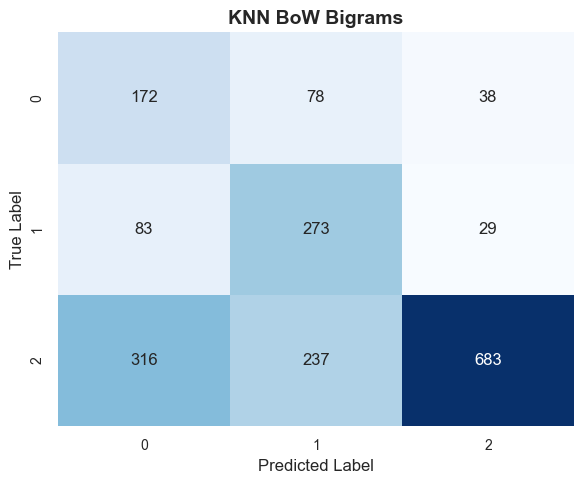

In [22]:
plot_confusion_matrix(y_val, y_val_pred_bow_bigrams, title=title, labels=[0, 1, 2], cmap="Blues")

## **2.2** TF-IDF

### **2.2.1** Unigrams

In [23]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = weights)

X_tfidf_unigrams, y_train_pred_tfidf_unigrams, y_val_pred_tfidf_unigrams, tfidf_unigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, model=modelknn)

In [24]:
tfidf_unigrams.get_feature_names_out()

array(['aa', 'aal', 'aaoi', ..., 'zyen', 'zynex', 'zynga'], dtype=object)

In [25]:
tfidf_unigrams.vocabulary_

{'nasdaq': 6781,
 'price': 7940,
 'percent': 7551,
 'senior': 9099,
 'note': 7013,
 'future': 4199,
 'up': 12012,
 'november': 7030,
 'nonfarm': 6970,
 'private': 7965,
 'payroll': 7503,
 'consensus': 2243,
 'ticker_econx': 10815,
 'twitter': 11857,
 'user': 12059,
 'explain': 3718,
 'kohl': 5680,
 'stock': 9730,
 'got': 4433,
 'obliterated': 7101,
 'reporting': 8502,
 'earnings': 3232,
 'agilysys': 260,
 'restaurant': 8564,
 'find': 3932,
 'sustainable': 9946,
 'method': 6448,
 'limiting': 5945,
 'food': 4045,
 'waste': 12304,
 'holiday': 4818,
 'make': 6173,
 'retirement': 8592,
 'top': 11647,
 'ranked': 8236,
 'mutual': 6738,
 'fund': 4186,
 'february': 3858,
 'could': 2391,
 'applied': 590,
 'dna': 3045,
 'science': 8990,
 'inc': 5094,
 'apdn': 569,
 'see': 9059,
 'reversal': 8616,
 'breaking': 1377,
 'week': 12353,
 'low': 6074,
 'lamp': 5746,
 'news': 6884,
 'usmca': 12062,
 'affect': 225,
 'usa': 12051,
 'steelmaker': 9693,
 'auto': 818,
 'manufacturer': 6220,
 'manchester': 620

In [26]:
# get the IDF score for each term
idf_dict = dict(zip(tfidf_unigrams.get_feature_names_out(), tfidf_unigrams.idf_))

# Get the first 10 items
idf_dict_10 = dict(list(idf_dict.items())[4100:4110])

print(idf_dict_10)

{'four': 6.995535198123193, 'fourth': 5.9509901307253585, 'fowl': 9.246826996729688, 'fox': 8.553679816169742, 'foxbusiness': 8.553679816169742, 'foxconn': 8.553679816169742, 'foxnews': 9.246826996729688, 'fpga': 9.246826996729688, 'fpp': 9.246826996729688, 'fpt': 9.246826996729688}


In [27]:
title = "KNN TF-IDF Unigrams"

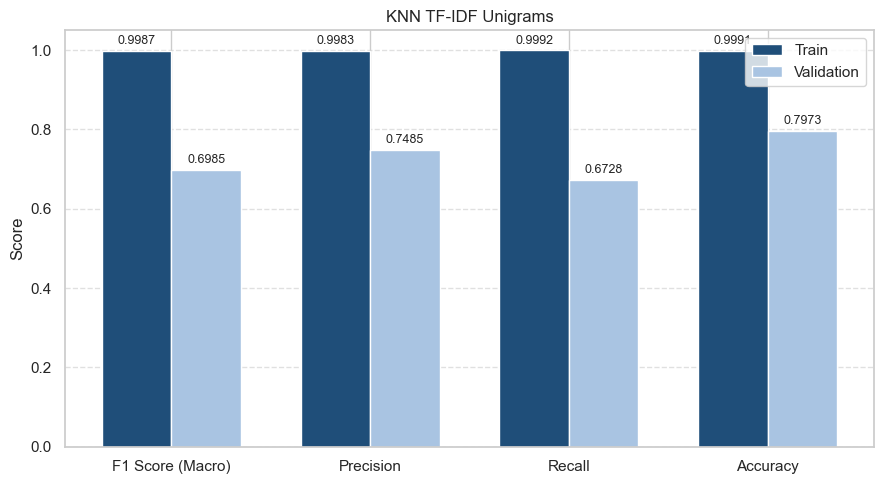

In [28]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_tfidf_unigrams, y_val, y_val_pred_tfidf_unigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_tfidf_unigrams, y_val, y_val_pred_tfidf_unigrams, title=title)

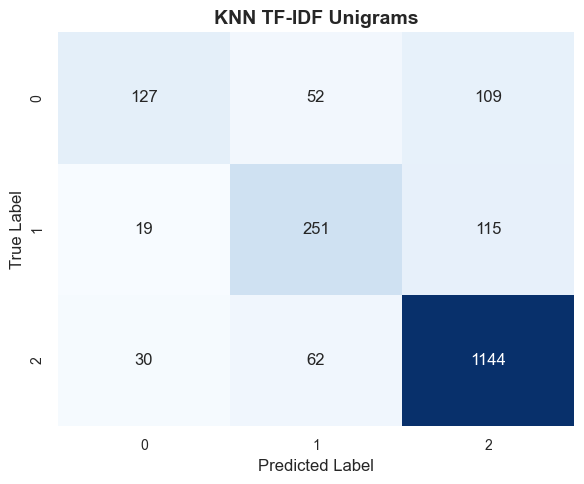

In [29]:
plot_confusion_matrix(y_val, y_val_pred_tfidf_unigrams, title=title, labels=[0, 1, 2], cmap="Blues")

### **2.2.2** Bigrams

In [30]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = weights)

X_tfidf_bigrams, y_train_pred_tfidf_bigrams, y_val_pred_tfidf_bigrams, tfidf_bigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, model=modelknn, ngram_range=(1,2))

In [31]:
tfidf_bigrams.get_feature_names_out()

array(['aa', 'aa cc', 'aal', ..., 'zynga', 'zynga nasdaq', 'zynga share'],
      dtype=object)

In [32]:
tfidf_bigrams.vocabulary_

{'nasdaq': 31116,
 'price': 36807,
 'percent': 34740,
 'senior': 42616,
 'note': 32303,
 'nasdaq price': 31201,
 'price percent': 36870,
 'percent percent': 34908,
 'percent senior': 34950,
 'senior note': 42629,
 'future': 19130,
 'up': 52401,
 'future up': 19176,
 'november': 32386,
 'nonfarm': 32196,
 'private': 37013,
 'payroll': 34549,
 'consensus': 10005,
 'ticker_econx': 49004,
 'november nonfarm': 32399,
 'nonfarm private': 32198,
 'private payroll': 37023,
 'payroll consensus': 34550,
 'consensus ticker_econx': 10021,
 'twitter': 51771,
 'user': 53151,
 'explain': 16662,
 'kohl': 25824,
 'stock': 45403,
 'got': 20386,
 'obliterated': 32723,
 'reporting': 39606,
 'earnings': 14509,
 'twitter user': 51788,
 'user explain': 53154,
 'explain kohl': 16663,
 'kohl stock': 25835,
 'stock got': 45477,
 'got obliterated': 20389,
 'obliterated reporting': 32724,
 'reporting earnings': 39608,
 'agilysys': 927,
 'restaurant': 39887,
 'find': 17839,
 'sustainable': 46648,
 'method': 29606,

In [33]:
# get the IDF score for each term
idf_dict = dict(zip(tfidf_bigrams.get_feature_names_out(), tfidf_bigrams.idf_))

# Get the first 10 items
idf_dict_10 = dict(list(idf_dict.items())[4100:4110])

print(idf_dict_10)

{'baxterinternational stock': 9.246826996729688, 'bayer': 8.330536264855532, 'bayer asks': 9.246826996729688, 'bayer face': 9.246826996729688, 'bayer plaintiff': 9.246826996729688, 'bayer seek': 9.246826996729688, 'bayer stock': 9.246826996729688, 'bayway': 9.246826996729688, 'bayway refinery': 9.246826996729688, 'bazooka': 8.841361888621524}


In [34]:
title = "KNN TF-IDF Bigrams"

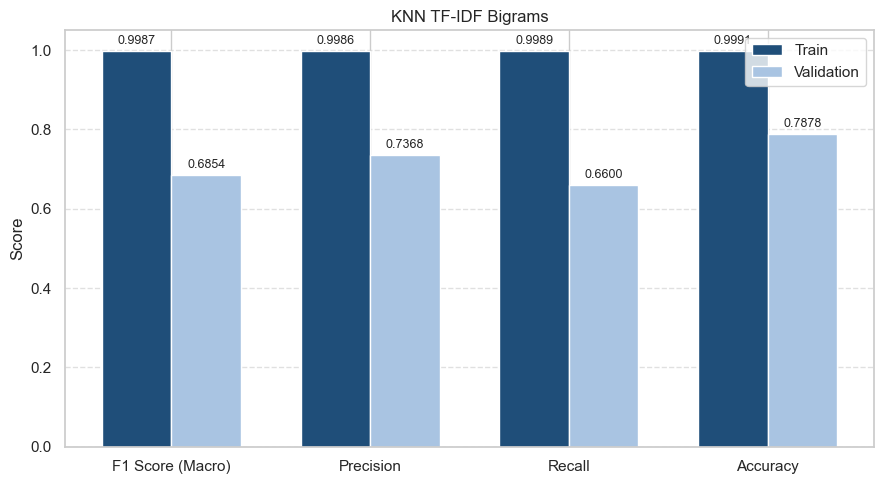

In [35]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_tfidf_bigrams, y_val, y_val_pred_tfidf_bigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_tfidf_bigrams, y_val, y_val_pred_tfidf_bigrams, title=title)

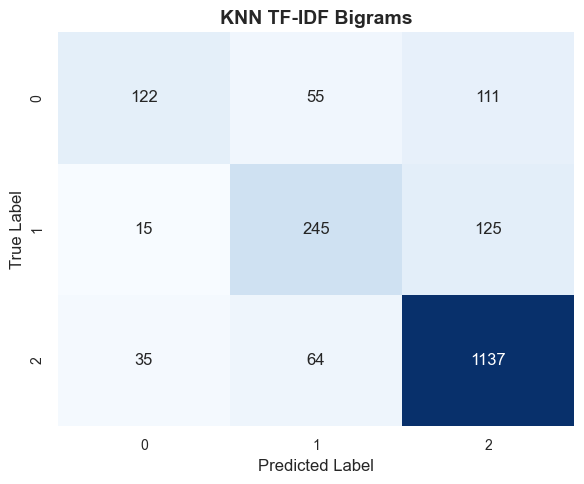

In [36]:
plot_confusion_matrix(y_val, y_val_pred_tfidf_bigrams, title=title, labels=[0, 1, 2], cmap="Blues")

## **2.3** Word2Vec

### **2.3.1** Minimum count = 1

In [37]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = weights)

X_train_vec, y_train_pred_vec, y_val_pred_vec = embedding_word2vec(x_train=x_train, y_train=y_train, x_val=x_val, window=window, min_count=min_count, model=modelknn)

In [38]:
title = "KNN Word2Vec"

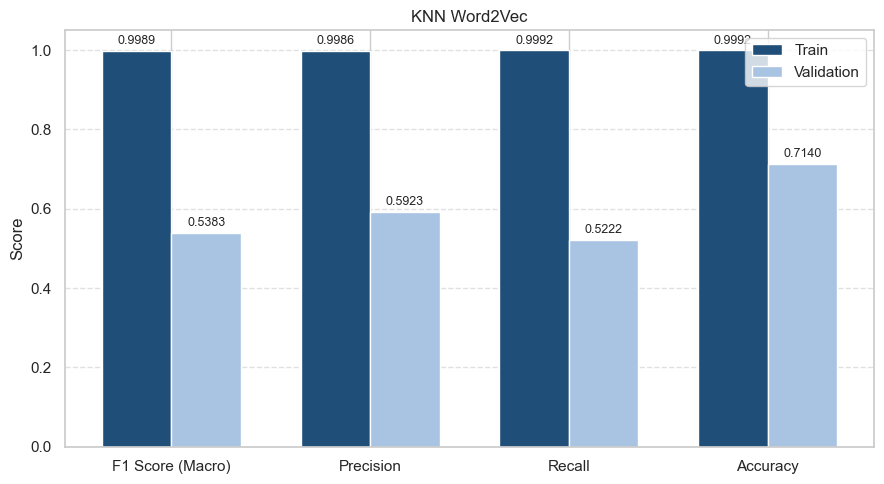

In [39]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_vec, y_val, y_val_pred_vec))

# Plot metrics
plot_metrics(y_train, y_train_pred_vec, y_val, y_val_pred_vec, title=title)

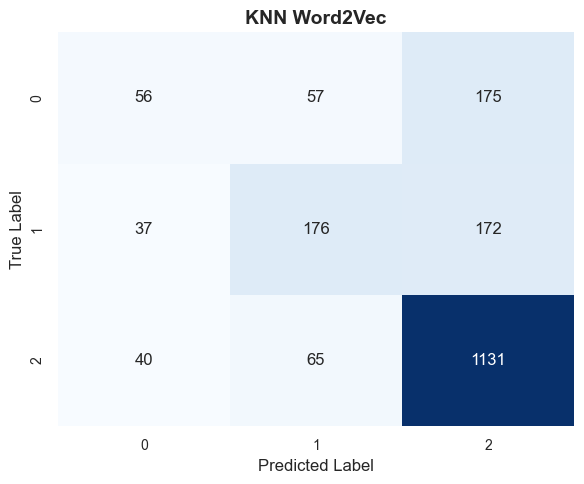

In [40]:
plot_confusion_matrix(y_val, y_val_pred_vec, title=title, labels=[0, 1, 2], cmap="Blues")

### **2.3.2** Minimum count based on percentile

In [41]:
tokenized_train = [word_tokenize(tweet.lower()) for tweet in x_train['text']]
all_tokens = [word for tweet in tokenized_train for word in tweet]

# frequency of each word
word_freq = Counter(all_tokens)
freq_values = np.array(list(word_freq.values()))

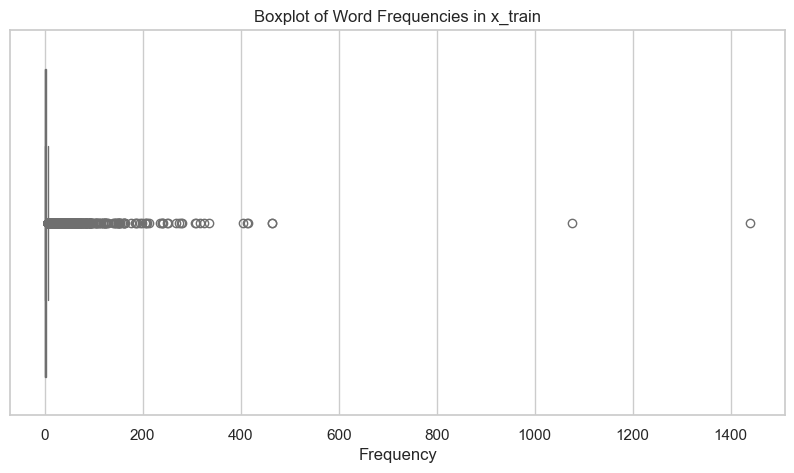

In [42]:
# boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x=freq_values, color='skyblue')
plt.title("Boxplot of Word Frequencies in x_train")
plt.xlabel("Frequency")
plt.show()

In [43]:
# 75th percentile
percentile_75 = int(np.percentile(freq_values, 75))

print(f"75th percentile: {percentile_75}")

75th percentile: 3


In [44]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = weights)

X_train_vec, y_train_pred_vec, y_val_pred_vec = embedding_word2vec(x_train=x_train, y_train=y_train, x_val=x_val, window=window, min_count=percentile_75, model=modelknn)

In [45]:
title = "KNN Word2Vec - Min count = 75th percentile"

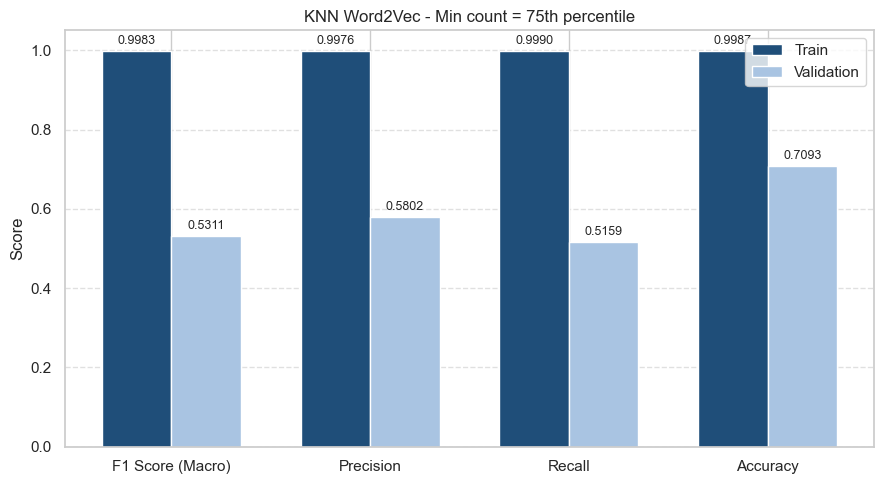

In [46]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_vec, y_val, y_val_pred_vec))

# Plot metrics
plot_metrics(y_train, y_train_pred_vec, y_val, y_val_pred_vec, title=title)

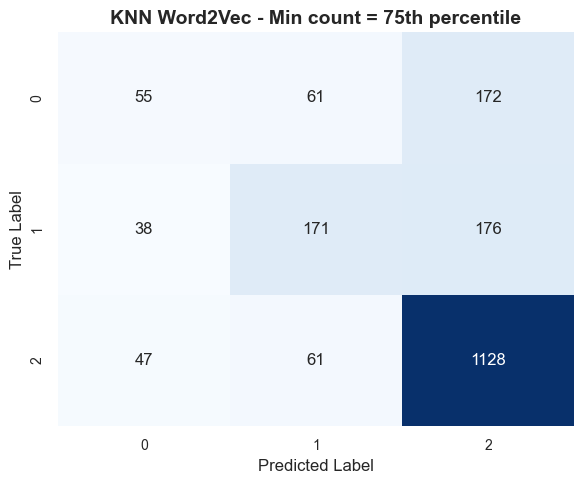

In [47]:
plot_confusion_matrix(y_val, y_val_pred_vec, title=title, labels=[0, 1, 2], cmap="Blues")

## **2.4** Glove

In [50]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = weights)

X_train_glove_avg, y_train_pred_glove, y_val_pred_glove = embedding_glove(x_train=x_train, y_train=y_train, x_val=x_val, model_glove = glove_model, emb_size=emb_size, model=modelknn)

100%|██████████| 1909/1909 [00:00<00:00, 23919.27it/s]


In [51]:
title = "KNN Glove"

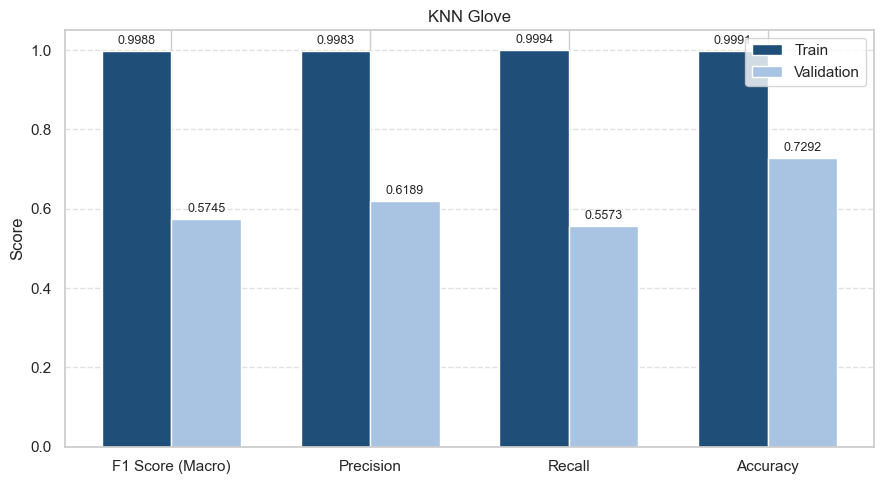

In [52]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_glove, y_val, y_val_pred_glove))

# Plot metrics
plot_metrics(y_train, y_train_pred_glove, y_val, y_val_pred_glove, title=title)

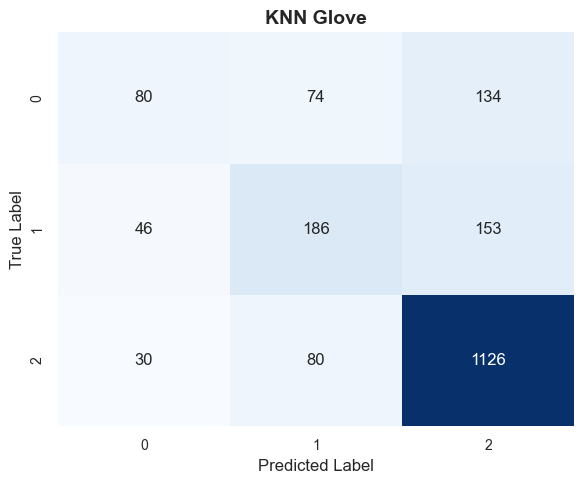

In [53]:
plot_confusion_matrix(y_val, y_val_pred_glove, title=title, labels=[0, 1, 2], cmap="Blues")

## **2.5** Text Embedding 3 Small - EXTRA

In [54]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = weights)

X_train_te3s, y_train_pred_te3s,y_val_pred_te3s = embedding_te3s(train_texts=train_texts,
                                                                 train_labels=train_labels,
                                                                 val_texts = val_texts, 
                                                                 cache_file_train="X_train_te3s_embeddings.pkl", 
                                                                 cache_file_val="X_val_te3s_embeddings.pkl",
                                                                 client=client,
                                                                 model_te3s=model_te3s,
                                                                 batch_size=32,
                                                                 model=modelknn)

Loading embeddings from X_train_te3s_embeddings.pkl...
Loading embeddings from X_val_te3s_embeddings.pkl...


In [55]:
# Define the title for the metrics and plots
title = "KNN with Text Embedding 3 Small"

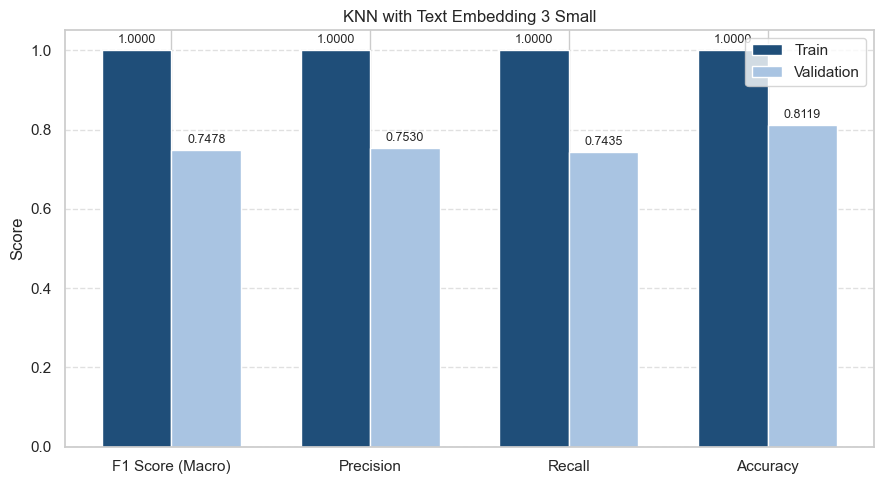

In [56]:
# Get metrics DataFrame
metrics_df.append(get_metrics_df(title, train_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s))
metrics_df

# Plot metrics
plot_metrics(train_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s, title=title)

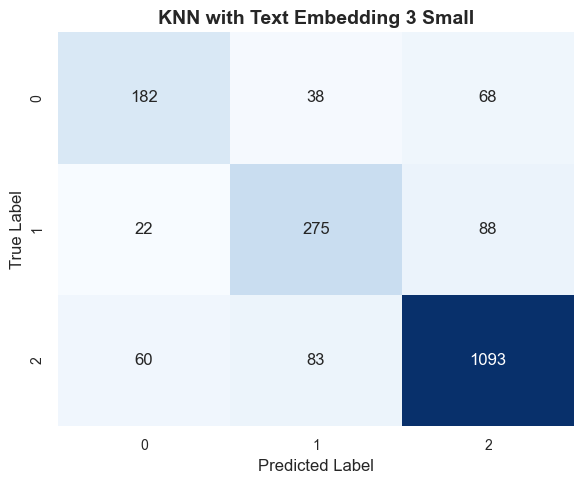

In [57]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, y_val_pred_te3s, title=title, labels=[0, 1, 2], cmap="Blues")

## **2.6** Twitter Roberta Base - EXTRA

In [58]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = weights)

X_train_roberta, y_train_pred_roberta,y_val_pred_roberta = embedding_roberta(train_texts=train_texts,
                                                                 train_labels=train_labels,
                                                                 val_texts = val_texts, 
                                                                 cache_file_train="X_train_te3s_embeddings.pkl", 
                                                                 cache_file_val="X_val_te3s_embeddings.pkl",
                                                                 tokenizer_roberta=tokenizer_roberta,
                                                                 model_roberta=model_roberta,
                                                                 batch_size=32,
                                                                 model=modelknn)

Loading RoBERTa embeddings from X_train_te3s_embeddings.pkl...
Loading RoBERTa embeddings from X_val_te3s_embeddings.pkl...


In [59]:
# Define the title for the metrics and plots
title = "KNN with RoBERTa"

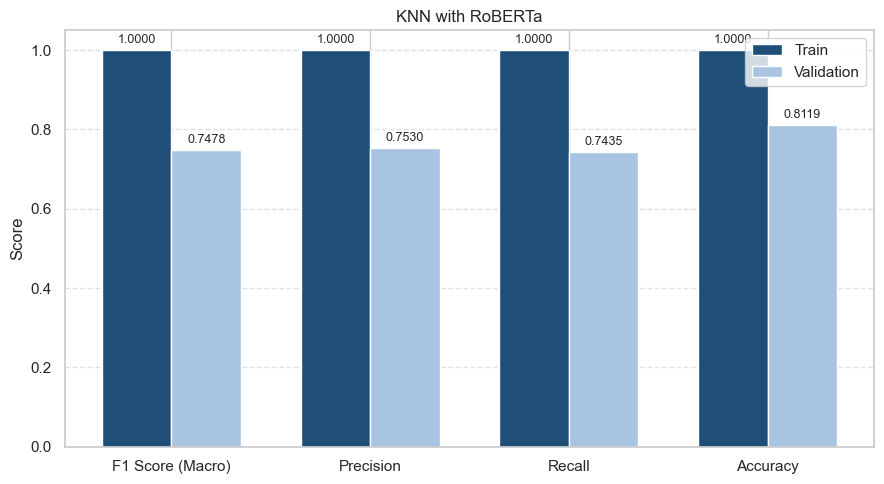

In [60]:
# Get metrics DataFrame
metrics_df.append(get_metrics_df(title, train_labels, y_train_pred_roberta, val_labels, y_val_pred_roberta))
metrics_df

# Plot metrics
plot_metrics(train_labels, y_train_pred_roberta, val_labels, y_val_pred_roberta, title=title)

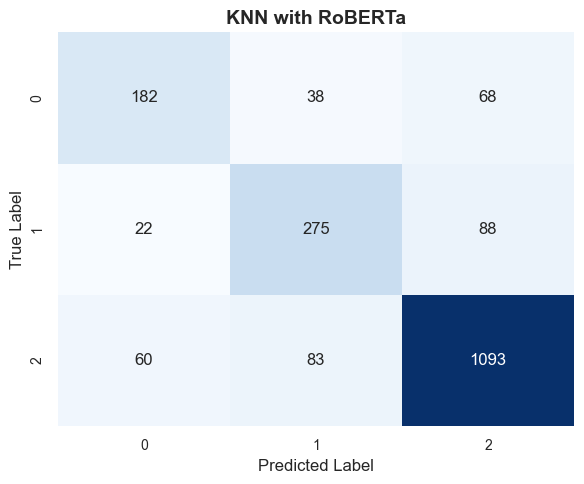

In [61]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, y_val_pred_roberta, title=title, labels=[0, 1, 2], cmap="Blues")

<div class="alert alert-block alert-success">

# **3.** **Naive Bayes**

<div>

We didn't use Word2Vec, Glove or Extra because they generate numbers that can be negative and Naive Bayes is based on probabilities and word frequencies, which must be non-negative — negative values don’t make sense in this context and would cause errors during training.

## **3.1** Bag of Words

### **3.1.1** Unigrams

In [62]:
model_nb = MultinomialNB(alpha=alpha)

# each term is marked as present or not per document - good for short text
X_bow_unigrams, y_train_pred_bow_unigrams, y_val_pred_bow_unigrams, bow_unigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, model=model_nb)

In [63]:
title = "Naive Bayes BoW Unigrams"

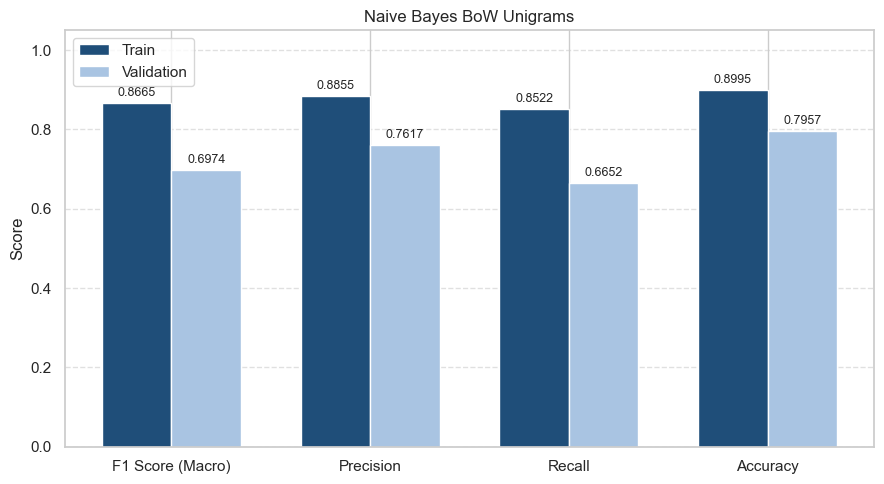

In [64]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_bow_unigrams, y_val, y_val_pred_bow_unigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_bow_unigrams, y_val, y_val_pred_bow_unigrams, title=title)

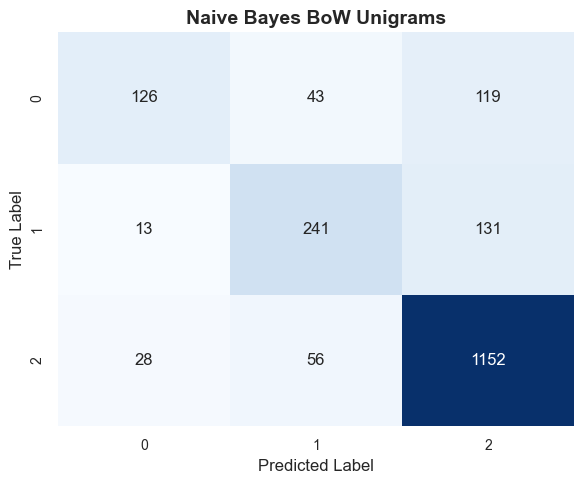

In [65]:
plot_confusion_matrix(y_val, y_val_pred_bow_unigrams, title=title, labels=[0, 1, 2], cmap="Blues")

### **3.1.2** Unigrams + Bigrams

In [66]:
model_nb = MultinomialNB(alpha=alpha)

X_bow_bigrams, y_train_pred_bow_bigrams, y_val_pred_bow_bigrams, bow_bigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, model=model_nb, ngram_range=(1,2))

In [67]:
title = "Naive Bayes BoW Bigrams"

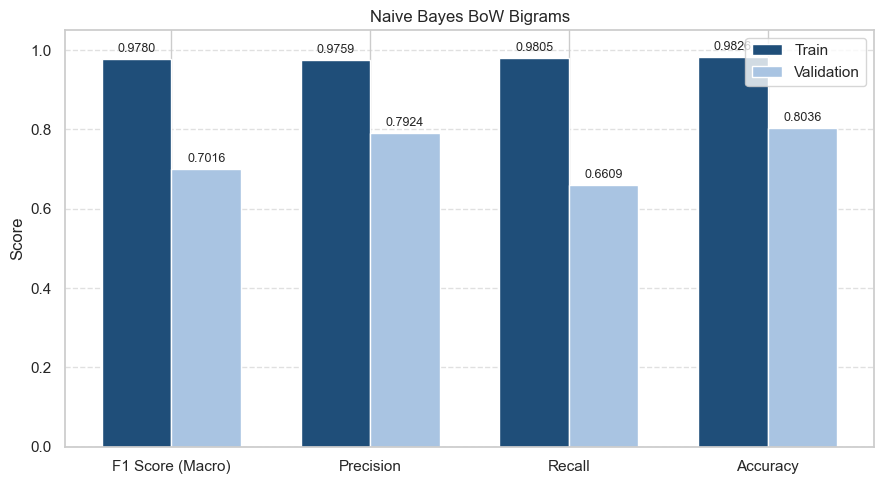

In [68]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_bow_bigrams, y_val, y_val_pred_bow_bigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_bow_bigrams, y_val, y_val_pred_bow_bigrams, title=title)

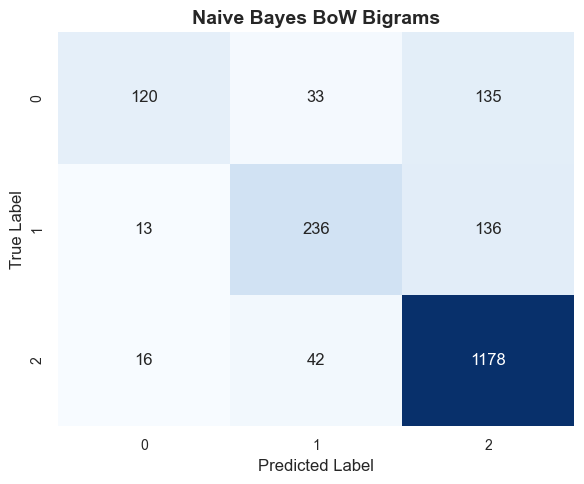

In [69]:
plot_confusion_matrix(y_val, y_val_pred_bow_bigrams, title=title, labels=[0, 1, 2], cmap="Blues")

## **3.2** TF-IDF

### **3.2.1** Unigrams

In [70]:
model_nb = MultinomialNB(alpha=alpha)

X_tfidf_unigrams, y_train_pred_tfidf_unigrams, y_val_pred_tfidf_unigrams, tfidf_unigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, model=model_nb)

In [71]:
title = "Naive Bayes TF-IDF Unigrams"

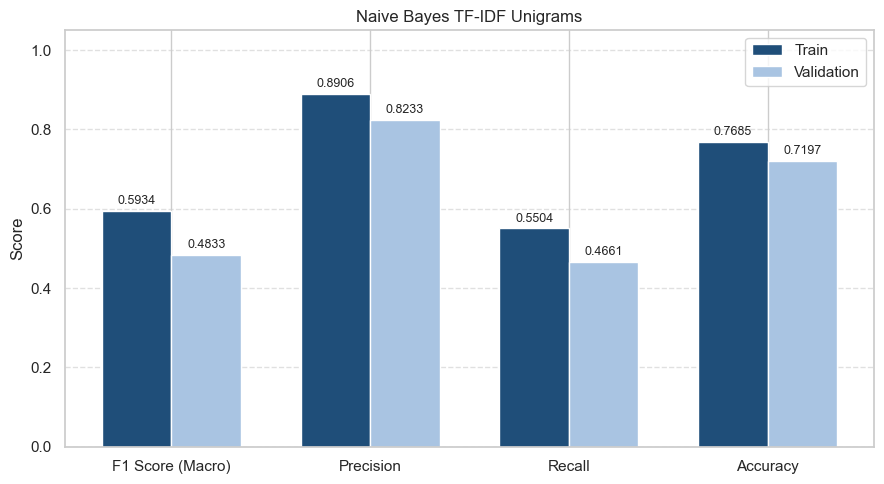

In [72]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_tfidf_unigrams, y_val, y_val_pred_tfidf_unigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_tfidf_unigrams, y_val, y_val_pred_tfidf_unigrams, title=title)

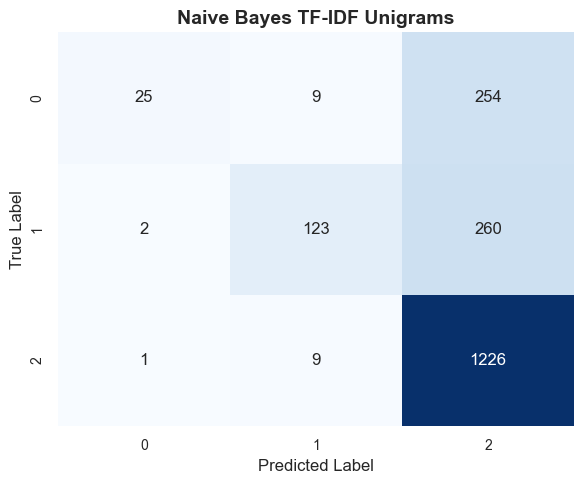

In [73]:
plot_confusion_matrix(y_val, y_val_pred_tfidf_unigrams, title=title, labels=[0, 1, 2], cmap="Blues")

### **3.2.2** Bigrams

In [74]:
model_nb = MultinomialNB(alpha=alpha)

X_tfidf_bigrams, y_train_pred_tfidf_bigrams, y_val_pred_tfidf_bigrams, tfidf_bigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, model=model_nb, ngram_range=(1,2))

In [75]:
title = "Naive Bayes TF-IDF Bigrams"

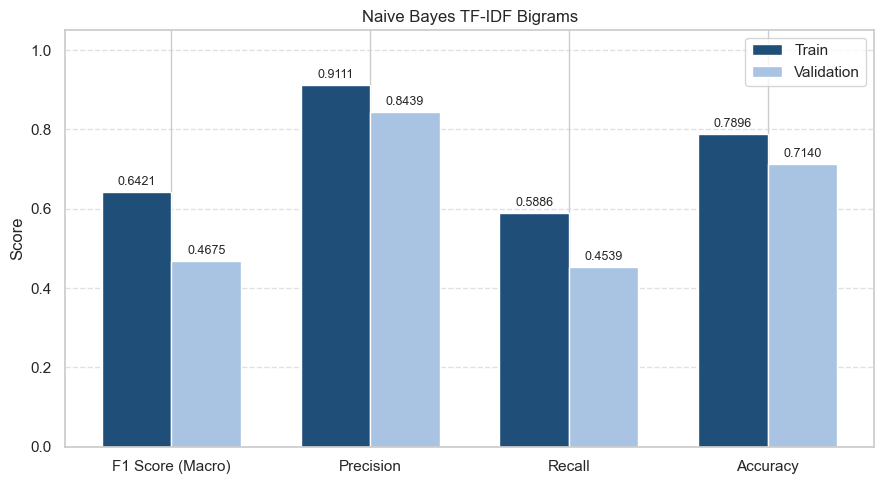

In [76]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_tfidf_bigrams, y_val, y_val_pred_tfidf_bigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_tfidf_bigrams, y_val, y_val_pred_tfidf_bigrams, title=title)

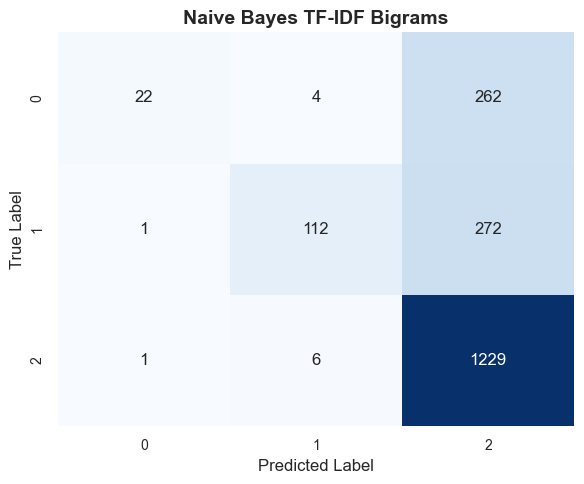

In [77]:
plot_confusion_matrix(y_val, y_val_pred_tfidf_bigrams, title=title, labels=[0, 1, 2], cmap="Blues")

<div class="alert alert-block alert-success">

# **4.** **Random Forest**

<div>

## **4.1** Bag of Words

### **4.1.1** Unigrams

In [78]:
model_rf = RandomForestClassifier(
    n_estimators=n_estimators,          
    criterion=criterion,         
    max_depth=max_depth,          
    min_samples_split=min_samples_split,      
    min_samples_leaf=min_samples_leaf,      
    max_features=max_features,
    class_weight=class_weight    
)

X_bow_unigrams, y_train_pred_bow_unigrams, y_val_pred_bow_unigrams, bow_unigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, model=model_rf)

In [79]:
title = "Random Forest BoW Unigrams"

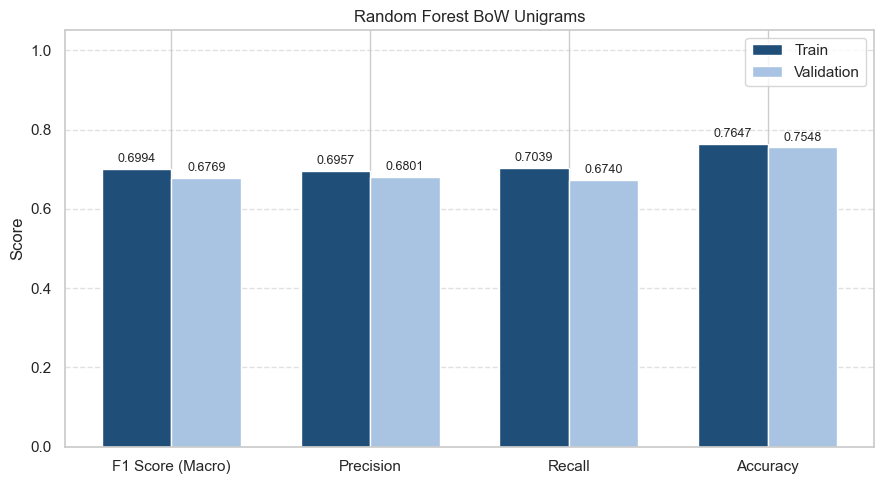

In [80]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_bow_unigrams, y_val, y_val_pred_bow_unigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_bow_unigrams, y_val, y_val_pred_bow_unigrams, title=title)

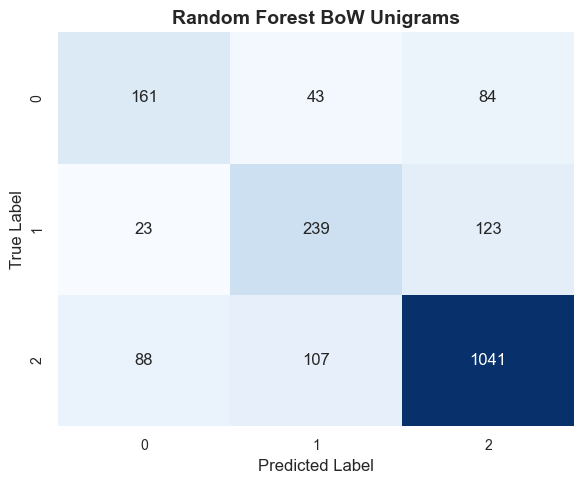

In [81]:
plot_confusion_matrix(y_val, y_val_pred_bow_unigrams, title=title, labels=[0, 1, 2], cmap="Blues")

### **4.1.2** Unigrams + Bigrams

In [82]:
model_rf = RandomForestClassifier(
    n_estimators=n_estimators,          
    criterion=criterion,         
    max_depth=max_depth,          
    min_samples_split=min_samples_split,      
    min_samples_leaf=min_samples_leaf,      
    max_features=max_features,
    class_weight=class_weight    
)

X_bow_bigrams, y_train_pred_bow_bigrams, y_val_pred_bow_bigrams, bow_bigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, model=model_rf, ngram_range=(1,2))

In [83]:
title = "Random Forest BoW Bigrams"

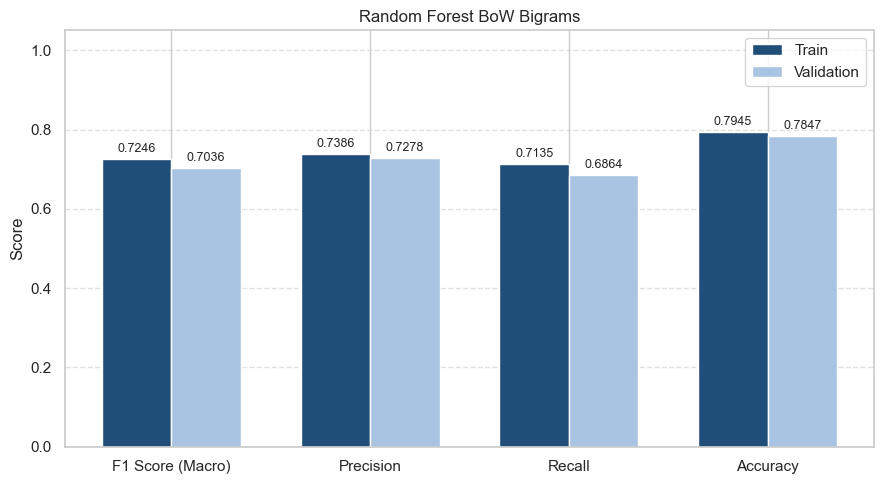

In [84]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_bow_bigrams, y_val, y_val_pred_bow_bigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_bow_bigrams, y_val, y_val_pred_bow_bigrams, title=title)

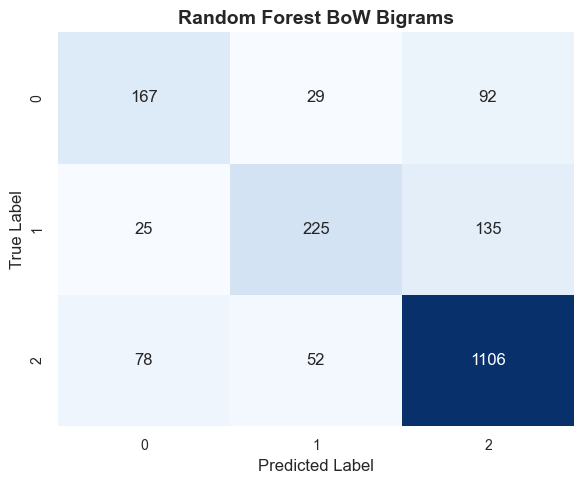

In [85]:
plot_confusion_matrix(y_val, y_val_pred_bow_bigrams, title=title, labels=[0, 1, 2], cmap="Blues")

## **4.2** TF-IDF

### **4.2.1** Unigrams

In [86]:
model_rf = RandomForestClassifier(
    n_estimators=n_estimators,          
    criterion=criterion,         
    max_depth=max_depth,          
    min_samples_split=min_samples_split,      
    min_samples_leaf=min_samples_leaf,      
    max_features=max_features,
    class_weight=class_weight    
)

X_tfidf_unigrams, y_train_pred_tfidf_unigrams, y_val_pred_tfidf_unigrams, tfidf_unigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, model=model_rf)

In [87]:
title = "Random Forest TF-IDF Unigrams"

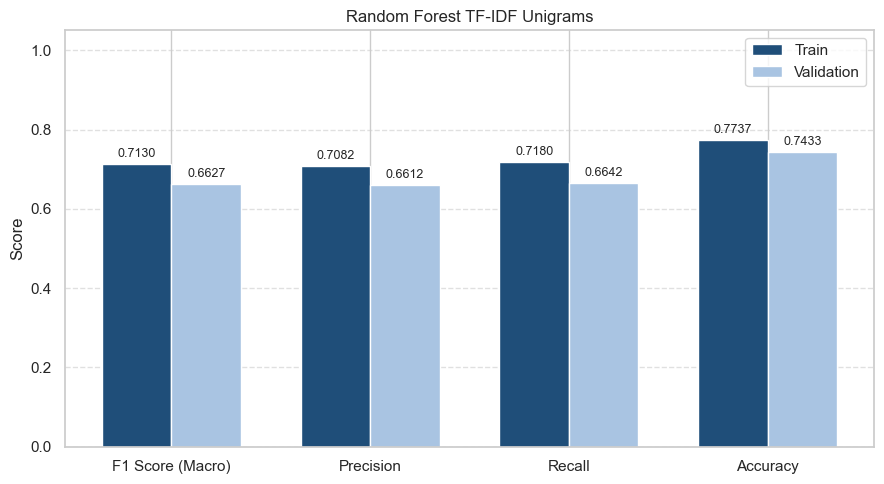

In [88]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_tfidf_unigrams, y_val, y_val_pred_tfidf_unigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_tfidf_unigrams, y_val, y_val_pred_tfidf_unigrams, title=title)

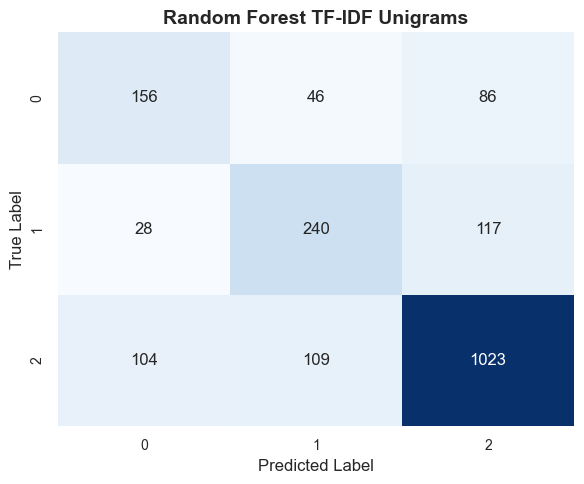

In [89]:
plot_confusion_matrix(y_val, y_val_pred_tfidf_unigrams, title=title, labels=[0, 1, 2], cmap="Blues")

### **4.2.2** Bigrams

In [90]:
model_rf = RandomForestClassifier(
    n_estimators=n_estimators,          
    criterion=criterion,         
    max_depth=max_depth,          
    min_samples_split=min_samples_split,      
    min_samples_leaf=min_samples_leaf,      
    max_features=max_features,
    class_weight=class_weight    
)

X_tfidf_bigrams, y_train_pred_tfidf_bigrams, y_val_pred_tfidf_bigrams, tfidf_bigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, model=model_rf, ngram_range=(1,2))

In [91]:
title = "Random Forest TF-IDF Bigrams"

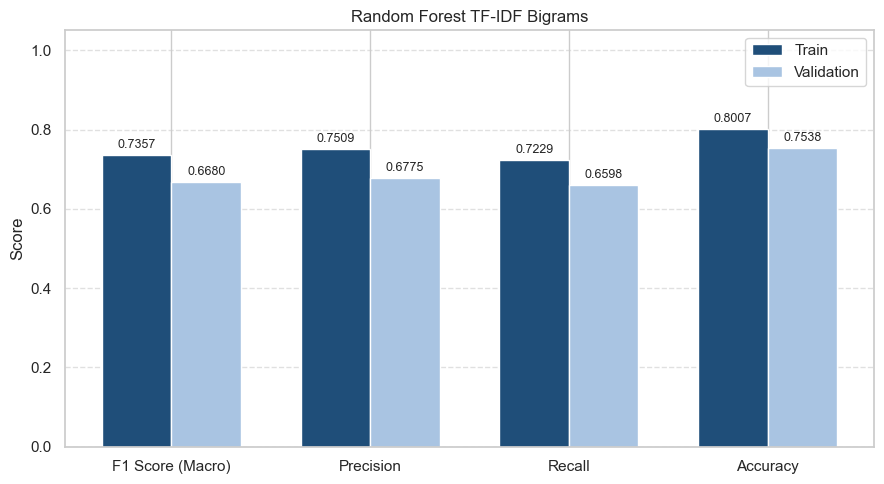

In [92]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_tfidf_bigrams, y_val, y_val_pred_tfidf_bigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_tfidf_bigrams, y_val, y_val_pred_tfidf_bigrams, title=title)

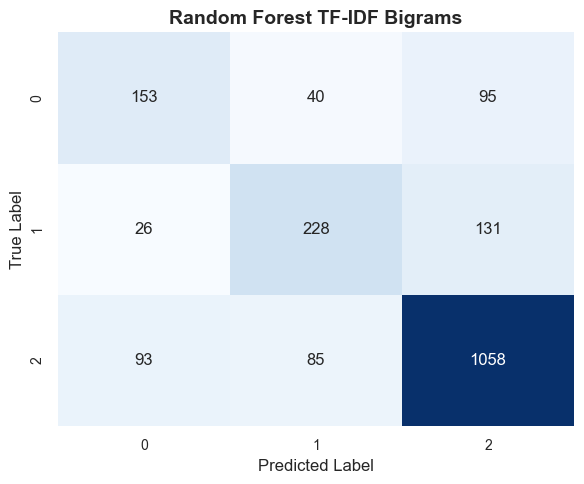

In [93]:
plot_confusion_matrix(y_val, y_val_pred_tfidf_bigrams, title=title, labels=[0, 1, 2], cmap="Blues")

## **4.3** Word2Vec

### **4.3.1** Minimum count = 1

In [94]:
model_rf = RandomForestClassifier(
    n_estimators=n_estimators,          
    criterion=criterion,         
    max_depth=max_depth,          
    min_samples_split=min_samples_split,      
    min_samples_leaf=min_samples_leaf,      
    max_features=max_features,
    class_weight=class_weight    
)

X_train_vec, y_train_pred_vec, y_val_pred_vec = embedding_word2vec(x_train=x_train, y_train=y_train, x_val=x_val, window=window, min_count=min_count, model=model_rf)

In [95]:
title = "Random Forest Word2Vec"

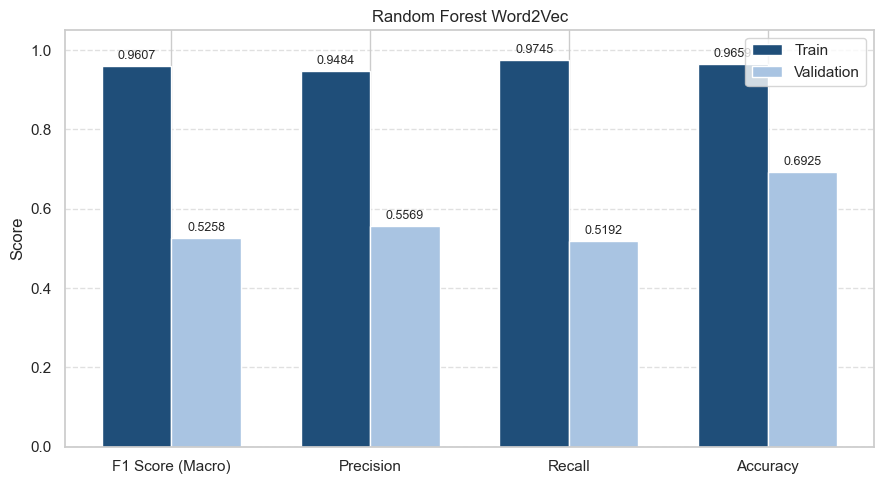

In [96]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_vec, y_val, y_val_pred_vec))

# Plot metrics
plot_metrics(y_train, y_train_pred_vec, y_val, y_val_pred_vec, title=title)

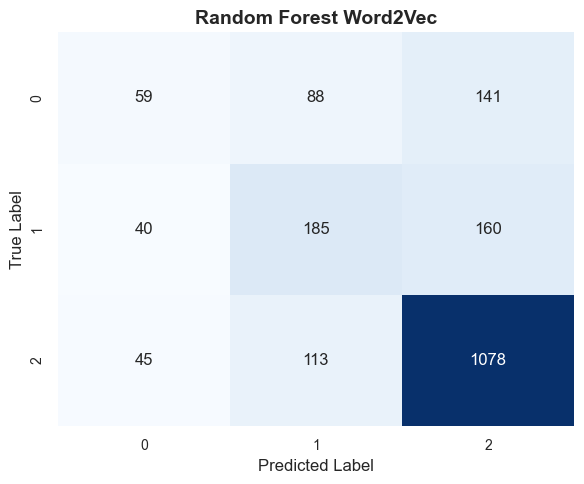

In [97]:
plot_confusion_matrix(y_val, y_val_pred_vec, title=title, labels=[0, 1, 2], cmap="Blues")

### **4.3.2** Minimum count based on percentile

In [98]:
model_rf = RandomForestClassifier(
    n_estimators=n_estimators,          
    criterion=criterion,         
    max_depth=max_depth,          
    min_samples_split=min_samples_split,      
    min_samples_leaf=min_samples_leaf,      
    max_features=max_features,
    class_weight=class_weight    
)

X_train_vec, y_train_pred_vec, y_val_pred_vec = embedding_word2vec(x_train=x_train, y_train=y_train, x_val=x_val, window=window, min_count=percentile_75, model=model_rf)

In [99]:
title = "Random Forest Word2Vec - Min count = 75th percentile"

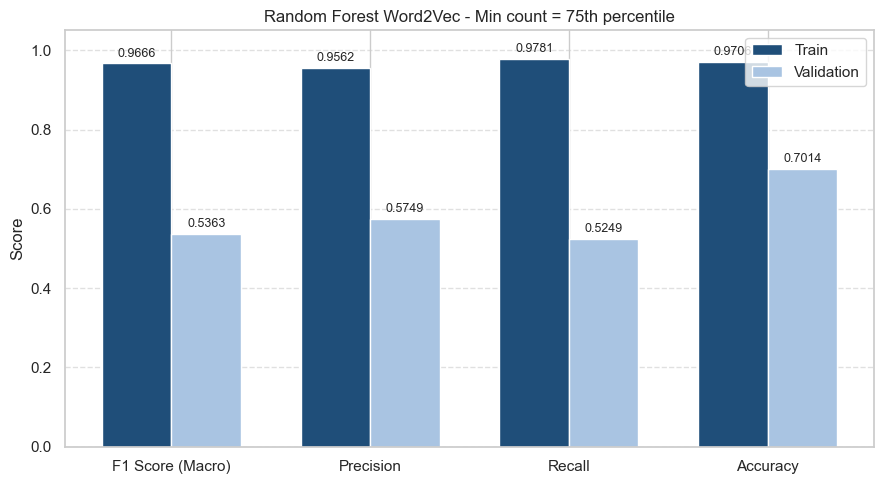

In [100]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_vec, y_val, y_val_pred_vec))

# Plot metrics
plot_metrics(y_train, y_train_pred_vec, y_val, y_val_pred_vec, title=title)

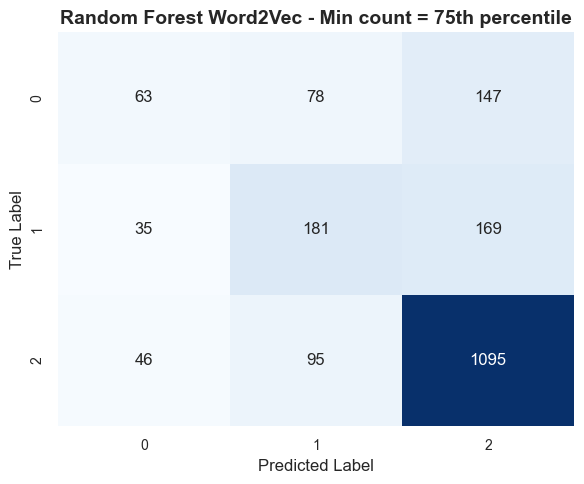

In [101]:
plot_confusion_matrix(y_val, y_val_pred_vec, title=title, labels=[0, 1, 2], cmap="Blues")

## **4.4** Glove

In [102]:
model_rf = RandomForestClassifier(
    n_estimators=n_estimators,          
    criterion=criterion,         
    max_depth=max_depth,          
    min_samples_split=min_samples_split,      
    min_samples_leaf=min_samples_leaf,      
    max_features=max_features,
    class_weight=class_weight    
)

X_train_glove_avg, y_train_pred_glove, y_val_pred_glove = embedding_glove(x_train=x_train, y_train=y_train, x_val=x_val, model_glove = glove_model, emb_size=emb_size, model=model_rf)

100%|██████████| 1909/1909 [00:00<00:00, 25482.56it/s]


In [103]:
title = "Random Forest Glove"

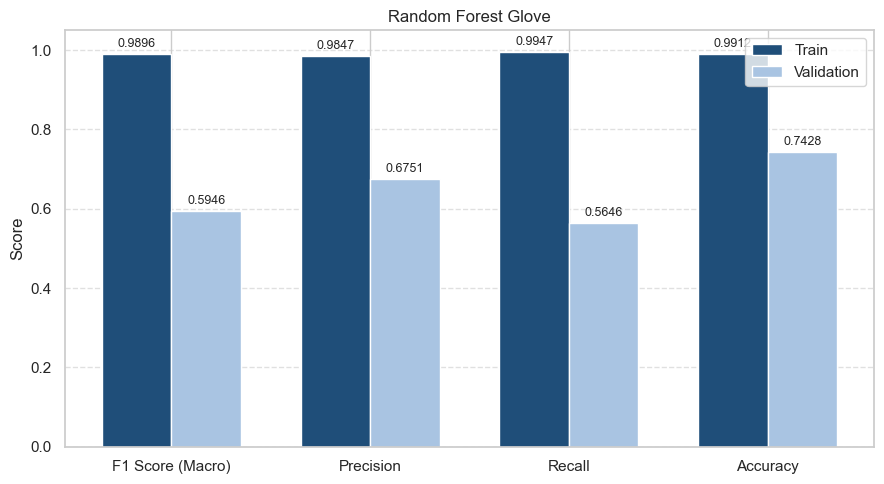

In [104]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_glove, y_val, y_val_pred_glove))

# Plot metrics
plot_metrics(y_train, y_train_pred_glove, y_val, y_val_pred_glove, title=title)

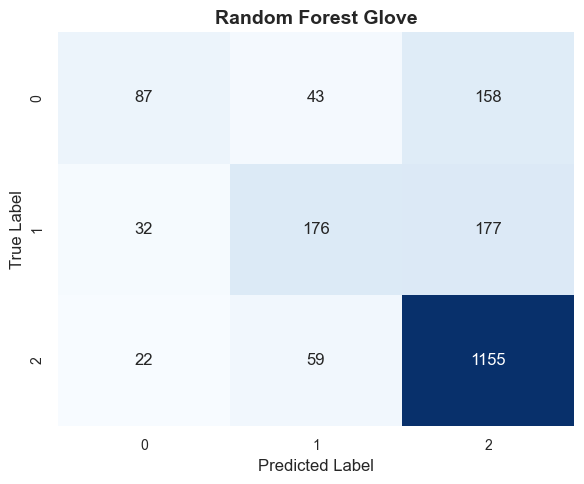

In [105]:
plot_confusion_matrix(y_val, y_val_pred_glove, title=title, labels=[0, 1, 2], cmap="Blues")

## **4.5** Text Embedding 3 Small - EXTRA

In [106]:
model_rf = RandomForestClassifier(
    n_estimators=n_estimators,          
    criterion=criterion,         
    max_depth=max_depth,          
    min_samples_split=min_samples_split,      
    min_samples_leaf=min_samples_leaf,      
    max_features=max_features,
    class_weight=class_weight    
)

X_train_te3s, y_train_pred_te3s,y_val_pred_te3s = embedding_te3s(train_texts=train_texts,
                                                                 train_labels=train_labels,
                                                                 val_texts = val_texts, 
                                                                 cache_file_train="X_train_te3s_embeddings.pkl", 
                                                                 cache_file_val="X_val_te3s_embeddings.pkl",
                                                                 client=client,
                                                                 model_te3s=model_te3s,
                                                                 batch_size=32,
                                                                 model=model_rf)

Loading embeddings from X_train_te3s_embeddings.pkl...
Loading embeddings from X_val_te3s_embeddings.pkl...


In [107]:
# Define the title for the metrics and plots
title = "Random Forest with Text Embedding 3 Small"

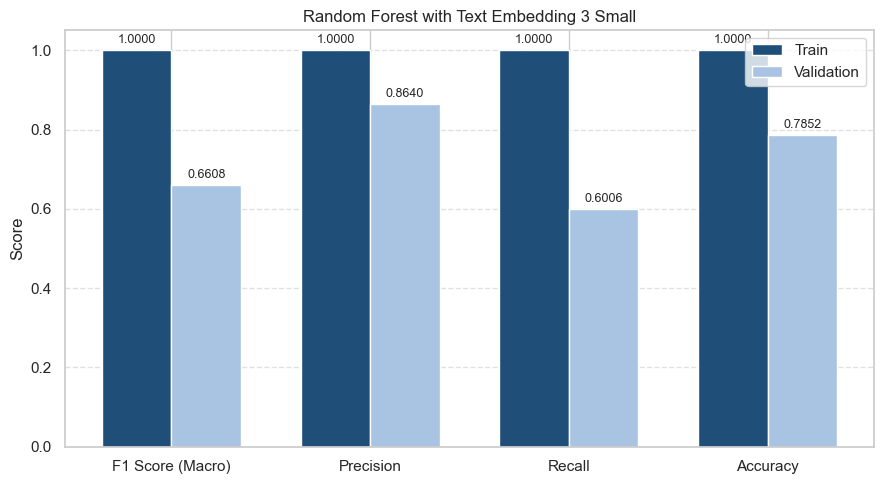

In [108]:
# Get metrics DataFrame
metrics_df.append(get_metrics_df(title, train_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s))
metrics_df

# Plot metrics
plot_metrics(train_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s, title=title)

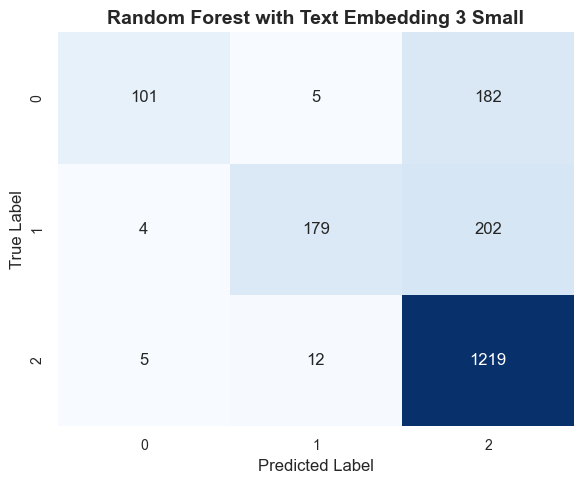

In [109]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, y_val_pred_te3s, title=title, labels=[0, 1, 2], cmap="Blues")

## **4.6** Twitter Roberta Base - EXTRA

In [110]:
model_rf = RandomForestClassifier(
    n_estimators=n_estimators,          
    criterion=criterion,         
    max_depth=max_depth,          
    min_samples_split=min_samples_split,      
    min_samples_leaf=min_samples_leaf,      
    max_features=max_features,
    class_weight=class_weight    
)

X_train_roberta, y_train_pred_roberta,y_val_pred_roberta = embedding_roberta(train_texts=train_texts,
                                                                 train_labels=train_labels,
                                                                 val_texts = val_texts, 
                                                                 cache_file_train="X_train_te3s_embeddings.pkl", 
                                                                 cache_file_val="X_val_te3s_embeddings.pkl",
                                                                 tokenizer_roberta=tokenizer_roberta,
                                                                 model_roberta=model_roberta,
                                                                 batch_size=32,
                                                                 model=model_rf)

Loading RoBERTa embeddings from X_train_te3s_embeddings.pkl...
Loading RoBERTa embeddings from X_val_te3s_embeddings.pkl...


In [111]:
# Define the title for the metrics and plots
title = "Random Forest with RoBERTa"

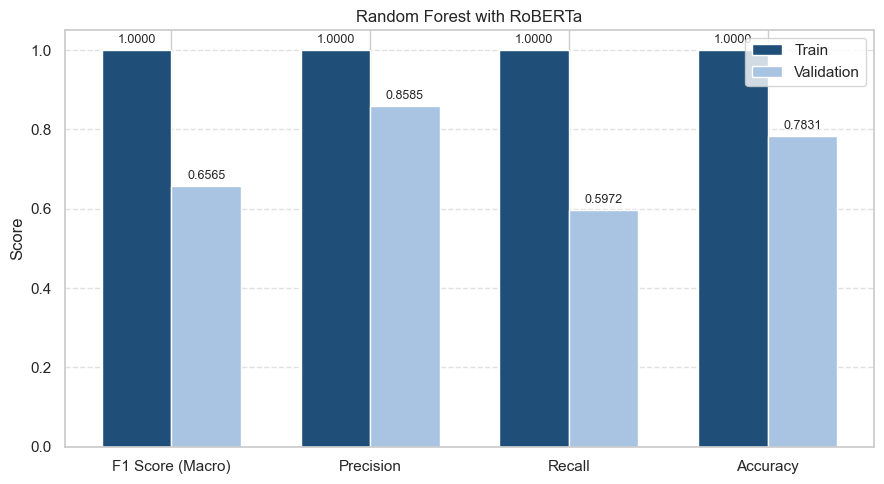

In [112]:
# Get metrics DataFrame
metrics_df.append(get_metrics_df(title, train_labels, y_train_pred_roberta, val_labels, y_val_pred_roberta))
metrics_df

# Plot metrics
plot_metrics(train_labels, y_train_pred_roberta, val_labels, y_val_pred_roberta, title=title)

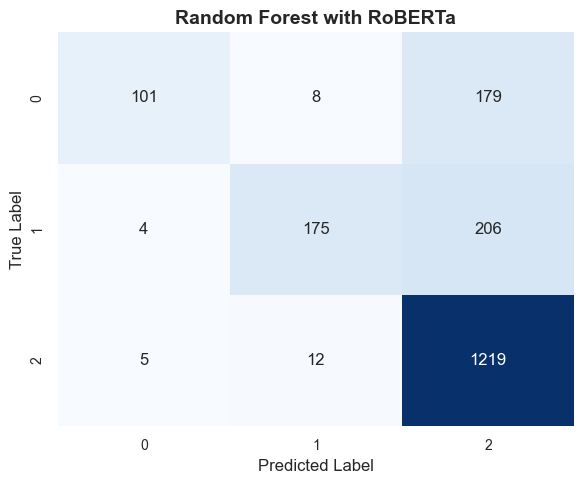

In [113]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, y_val_pred_roberta, title=title, labels=[0, 1, 2], cmap="Blues")

<div class="alert alert-block alert-success">

# **5.** **Logistic Regression**

<div>

## **5.1** Bag of Words

### **5.1.1** Unigrams

In [114]:
model_lr = LogisticRegression(
    penalty=penalty, 
    solver=solver, 
    l1_ratio=l1_ratio, 
    C=C, 
    class_weight=class_weight, 
    max_iter=max_iter, 
    multi_class=multi_class
)

X_bow_unigrams, y_train_pred_bow_unigrams, y_val_pred_bow_unigrams, bow_unigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, model=model_lr)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [115]:
title = "LR BoW Unigrams"

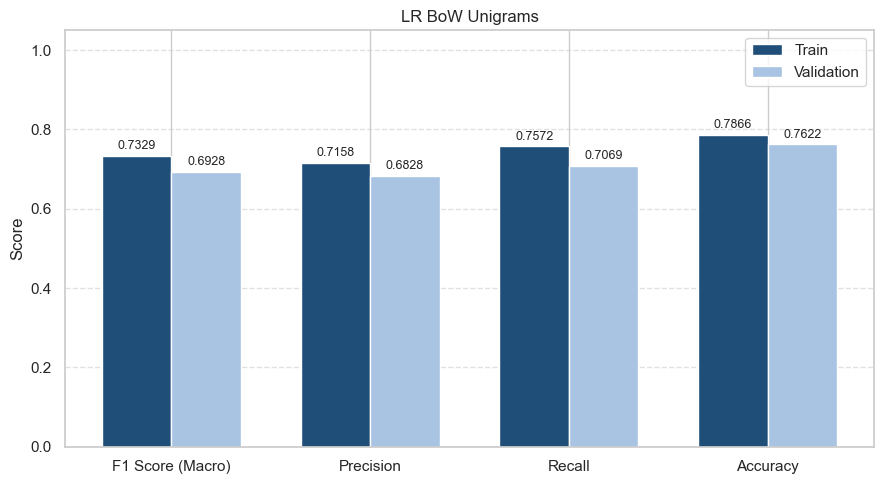

In [116]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_bow_unigrams, y_val, y_val_pred_bow_unigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_bow_unigrams, y_val, y_val_pred_bow_unigrams, title=title)

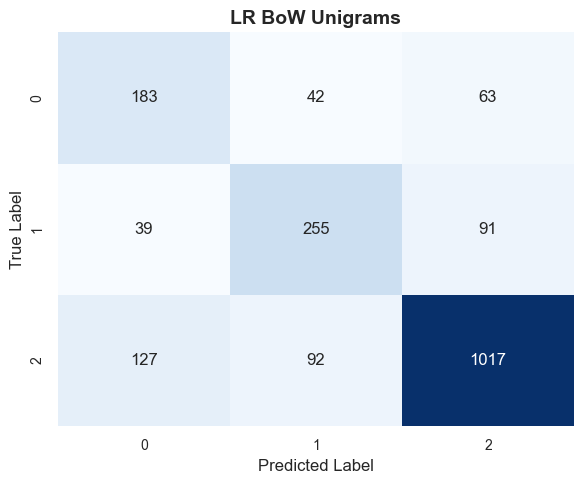

In [117]:
plot_confusion_matrix(y_val, y_val_pred_bow_unigrams, title=title, labels=[0, 1, 2], cmap="Blues")

### **5.1.2** Unigrams + Bigrams

In [118]:
model_lr = LogisticRegression(
    penalty=penalty, 
    solver=solver, 
    l1_ratio=l1_ratio, 
    C=C, 
    class_weight=class_weight, 
    max_iter=max_iter, 
    multi_class=multi_class
)

X_bow_bigrams, y_train_pred_bow_bigrams, y_val_pred_bow_bigrams, bow_bigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, model=model_lr, ngram_range=(1,2))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [119]:
title = "LR BoW Bigrams"

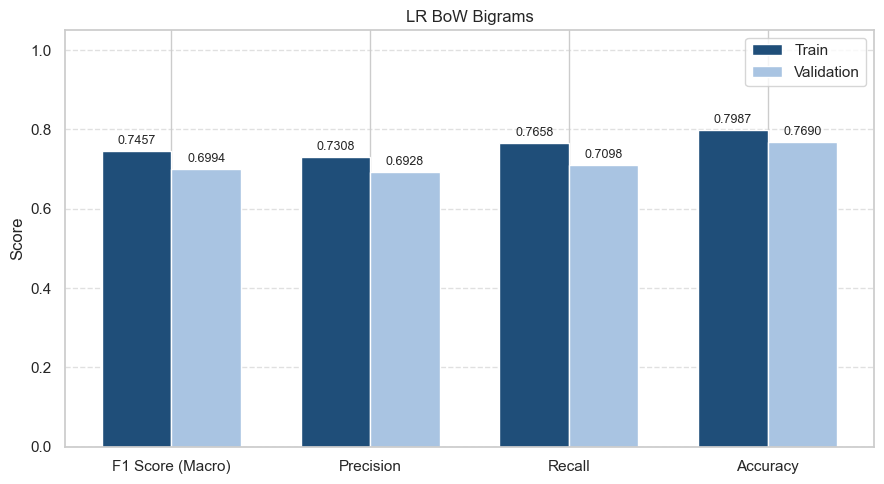

In [120]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_bow_bigrams, y_val, y_val_pred_bow_bigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_bow_bigrams, y_val, y_val_pred_bow_bigrams, title=title)

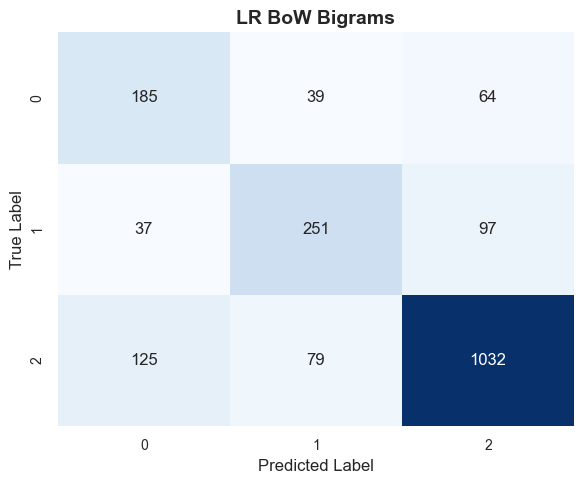

In [121]:
plot_confusion_matrix(y_val, y_val_pred_bow_bigrams, title=title, labels=[0, 1, 2], cmap="Blues")

## **5.2** TF-IDF

### **5.2.1** Unigrams

In [122]:
model_lr = LogisticRegression(
    penalty=penalty, 
    solver=solver, 
    l1_ratio=l1_ratio, 
    C=C, 
    class_weight=class_weight, 
    max_iter=max_iter, 
    multi_class=multi_class
)

X_tfidf_unigrams, y_train_pred_tfidf_unigrams, y_val_pred_tfidf_unigrams, tfidf_unigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, model=model_lr,oversampling_function=oversample)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [123]:
title = "LR TF-IDF Unigrams"

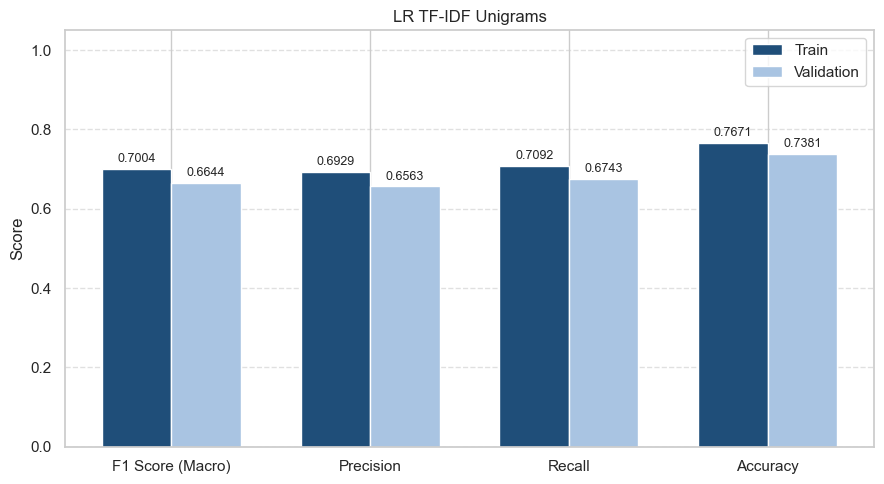

In [124]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_tfidf_unigrams, y_val, y_val_pred_tfidf_unigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_tfidf_unigrams, y_val, y_val_pred_tfidf_unigrams, title=title)

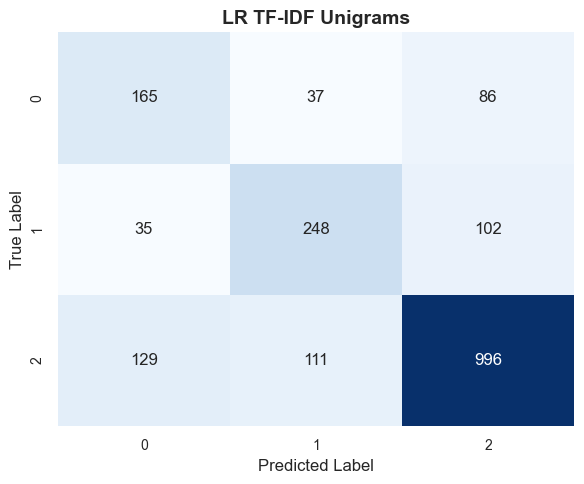

In [125]:
plot_confusion_matrix(y_val, y_val_pred_tfidf_unigrams, title=title, labels=[0, 1, 2], cmap="Blues")

### **5.2.2** Bigrams

In [126]:
model_lr = LogisticRegression(
    penalty=penalty, 
    solver=solver, 
    l1_ratio=l1_ratio, 
    C=C, 
    class_weight=class_weight, 
    max_iter=max_iter, 
    multi_class=multi_class
)

X_tfidf_bigrams, y_train_pred_tfidf_bigrams, y_val_pred_tfidf_bigrams, tfidf_bigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, model=model_lr, ngram_range=(1,2))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [127]:
title = "LR TF-IDF Bigrams"

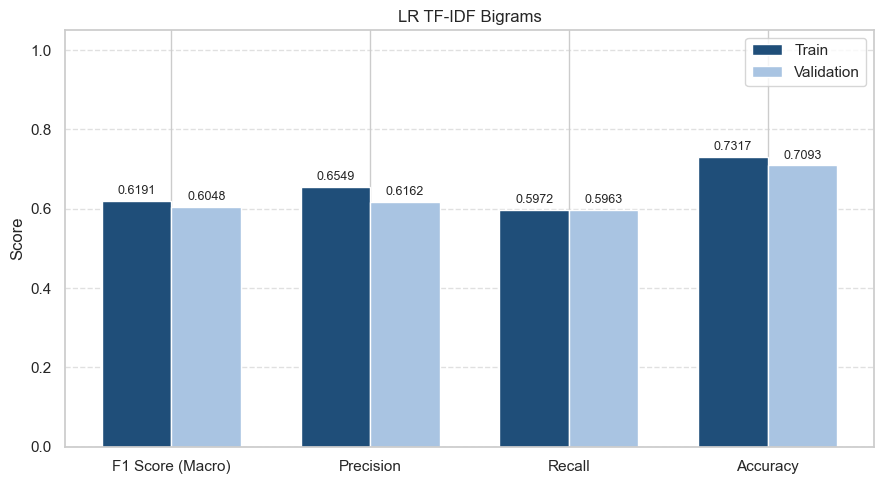

In [128]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_tfidf_bigrams, y_val, y_val_pred_tfidf_bigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_tfidf_bigrams, y_val, y_val_pred_tfidf_bigrams, title=title)

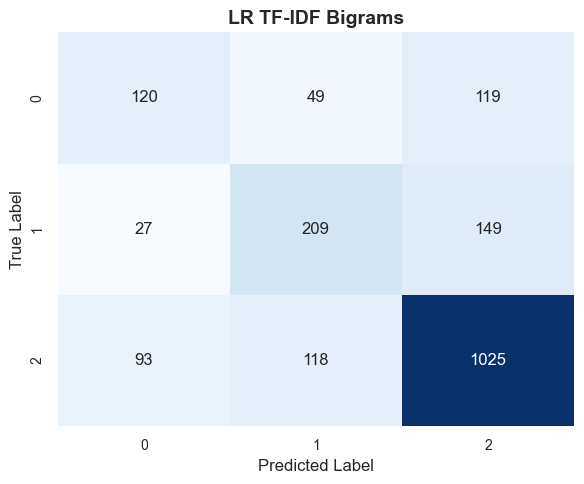

In [129]:
plot_confusion_matrix(y_val, y_val_pred_tfidf_bigrams, title=title, labels=[0, 1, 2], cmap="Blues")

## **5.3** Word2Vec

### **5.3.1** Minimum count = 1

In [130]:
model_lr = LogisticRegression(
    penalty=penalty, 
    solver=solver, 
    l1_ratio=l1_ratio, 
    C=C, 
    class_weight=class_weight, 
    max_iter=max_iter, 
    multi_class=multi_class
)

X_train_vec, y_train_pred_vec, y_val_pred_vec = embedding_word2vec(x_train=x_train, y_train=y_train, x_val=x_val, window=window, min_count=min_count, model=model_lr)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [131]:
title = "LR Word2Vec"

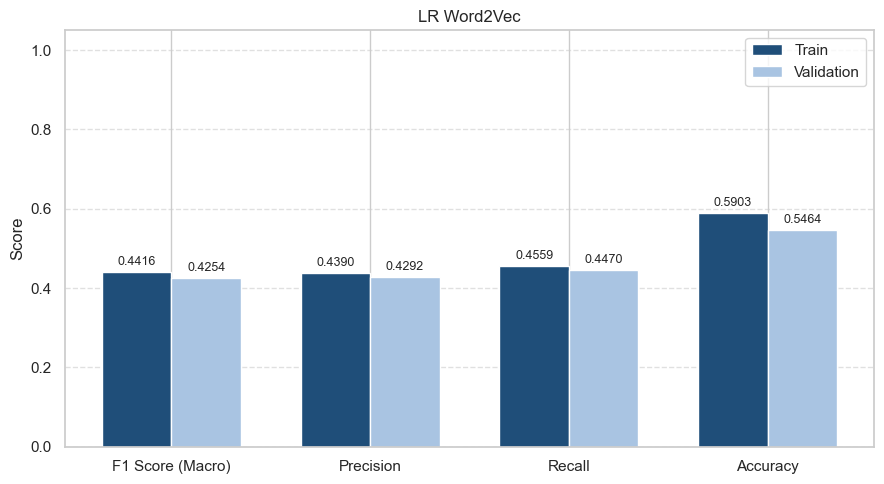

In [132]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_vec, y_val, y_val_pred_vec))

# Plot metrics
plot_metrics(y_train, y_train_pred_vec, y_val, y_val_pred_vec, title=title)

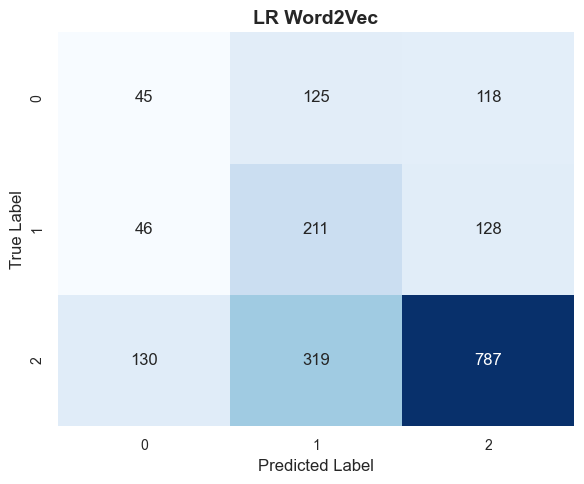

In [133]:
plot_confusion_matrix(y_val, y_val_pred_vec, title=title, labels=[0, 1, 2], cmap="Blues")

### **5.3.2** Minimum count based on percentile

In [134]:
X_train_vec, y_train_pred_vec, y_val_pred_vec = embedding_word2vec(x_train=x_train, y_train=y_train, x_val=x_val, window=window, min_count=percentile_75, model=model_lr)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [135]:
title = "LR Word2Vec - Min count = 75th percentile"

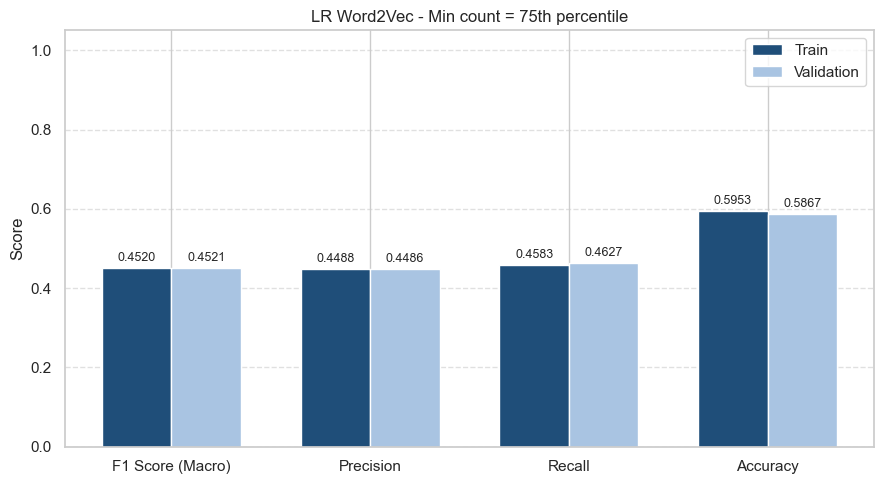

In [136]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_vec, y_val, y_val_pred_vec))

# Plot metrics
plot_metrics(y_train, y_train_pred_vec, y_val, y_val_pred_vec, title=title)

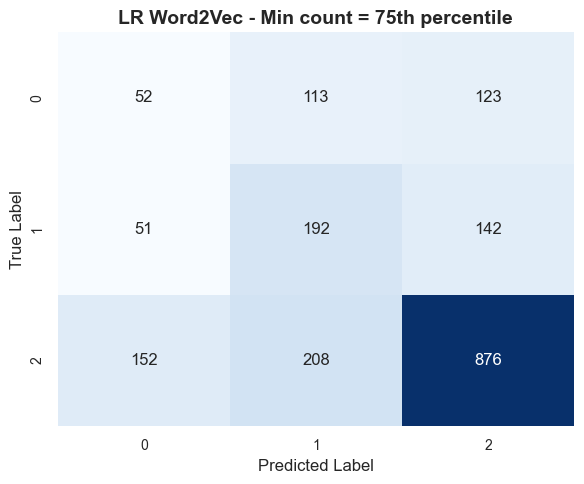

In [137]:
plot_confusion_matrix(y_val, y_val_pred_vec, title=title, labels=[0, 1, 2], cmap="Blues")

## **5.4** Glove

In [138]:
model_lr = LogisticRegression(
    penalty=penalty, 
    solver=solver, 
    l1_ratio=l1_ratio, 
    C=C, 
    class_weight=class_weight, 
    max_iter=max_iter, 
    multi_class=multi_class
)

X_train_glove_avg, y_train_pred_glove, y_val_pred_glove = embedding_glove(x_train=x_train, y_train=y_train, x_val=x_val, model_glove = glove_model, emb_size=emb_size, model=model_lr)

100%|██████████| 1909/1909 [00:00<00:00, 25316.26it/s]
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [139]:
title = "LR Glove"

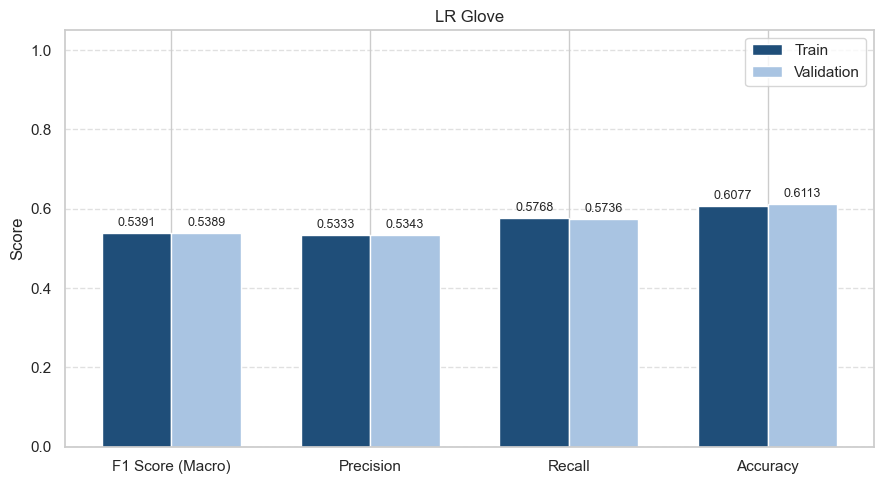

In [140]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_glove, y_val, y_val_pred_glove))

# Plot metrics
plot_metrics(y_train, y_train_pred_glove, y_val, y_val_pred_glove, title=title)

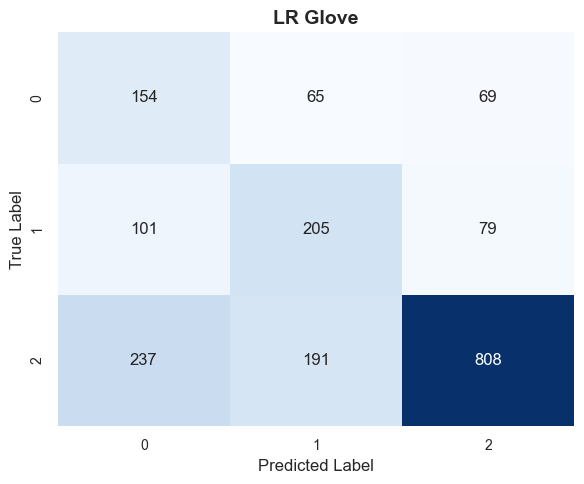

In [141]:
plot_confusion_matrix(y_val, y_val_pred_glove, title=title, labels=[0, 1, 2], cmap="Blues")

## **5.5** Text Embedding 3 Small - EXTRA

In [142]:
model_lr = LogisticRegression(
    penalty=penalty, 
    solver=solver, 
    l1_ratio=l1_ratio, 
    C=C, 
    class_weight=class_weight, 
    max_iter=max_iter, 
    multi_class=multi_class
)

X_train_te3s, y_train_pred_te3s,y_val_pred_te3s = embedding_te3s(train_texts=train_texts,
                                                                 train_labels=train_labels,
                                                                 val_texts = val_texts, 
                                                                 cache_file_train="X_train_te3s_embeddings.pkl", 
                                                                 cache_file_val="X_val_te3s_embeddings.pkl",
                                                                 client=client,
                                                                 model_te3s=model_te3s,
                                                                 batch_size=32,
                                                                 model=model_lr)

Loading embeddings from X_train_te3s_embeddings.pkl...
Loading embeddings from X_val_te3s_embeddings.pkl...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [143]:
# Define the title for the metrics and plots
title = "Logistic Regression with Text Embedding 3 Small"

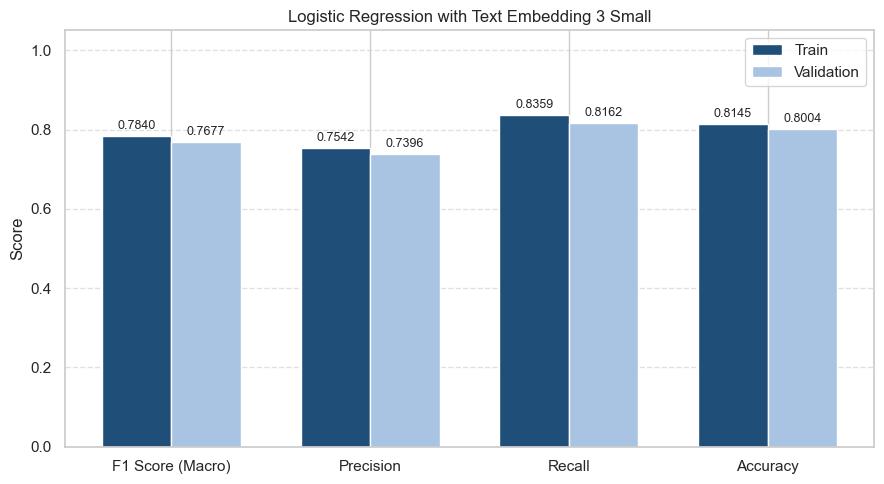

In [144]:
# Get metrics DataFrame
metrics_df.append(get_metrics_df(title, train_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s))
metrics_df

# Plot metrics
plot_metrics(train_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s, title=title)

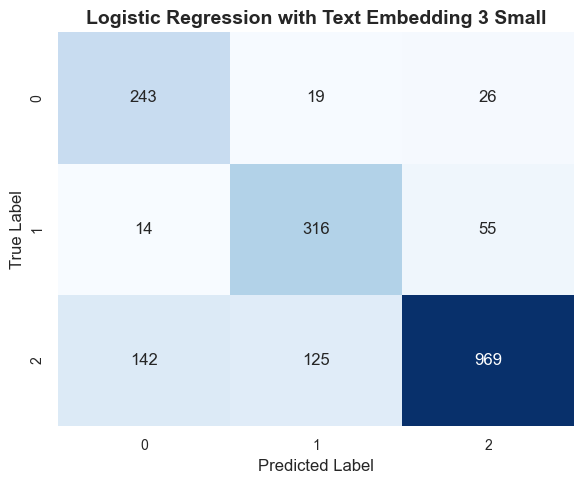

In [145]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, y_val_pred_te3s, title=title, labels=[0, 1, 2], cmap="Blues")

## **5.6** Twitter Roberta Base - EXTRA

In [146]:
model_lr = LogisticRegression(
    penalty=penalty, 
    solver=solver, 
    l1_ratio=l1_ratio, 
    C=C, 
    class_weight=class_weight, 
    max_iter=max_iter, 
    multi_class=multi_class
)

X_train_roberta, y_train_pred_roberta,y_val_pred_roberta = embedding_roberta(train_texts=train_texts,
                                                                 train_labels=train_labels,
                                                                 val_texts = val_texts, 
                                                                 cache_file_train="X_train_te3s_embeddings.pkl", 
                                                                 cache_file_val="X_val_te3s_embeddings.pkl",
                                                                 tokenizer_roberta=tokenizer_roberta,
                                                                 model_roberta=model_roberta,
                                                                 batch_size=32,
                                                                 model=model_lr)

Loading RoBERTa embeddings from X_train_te3s_embeddings.pkl...
Loading RoBERTa embeddings from X_val_te3s_embeddings.pkl...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [147]:
# Define the title for the metrics and plots
title = "Logistic Regression with RoBERTa"

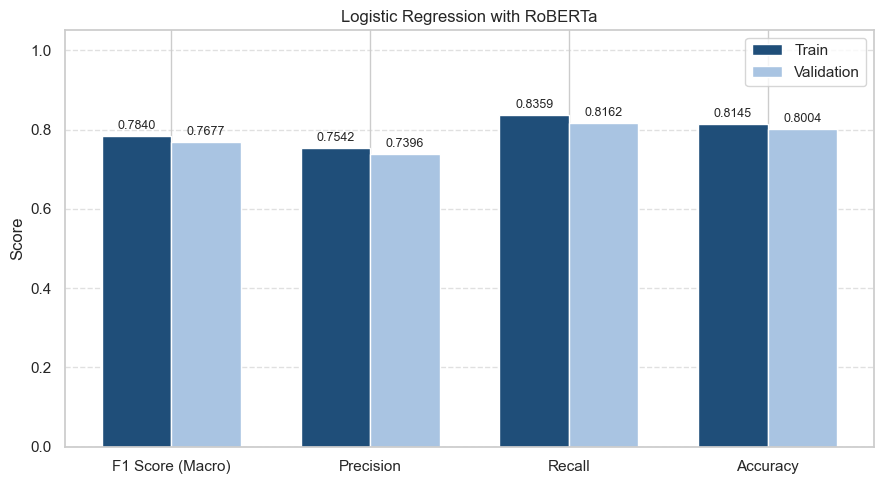

In [148]:
# Get metrics DataFrame
metrics_df.append(get_metrics_df(title, train_labels, y_train_pred_roberta, val_labels, y_val_pred_roberta))
metrics_df

# Plot metrics
plot_metrics(train_labels, y_train_pred_roberta, val_labels, y_val_pred_roberta, title=title)

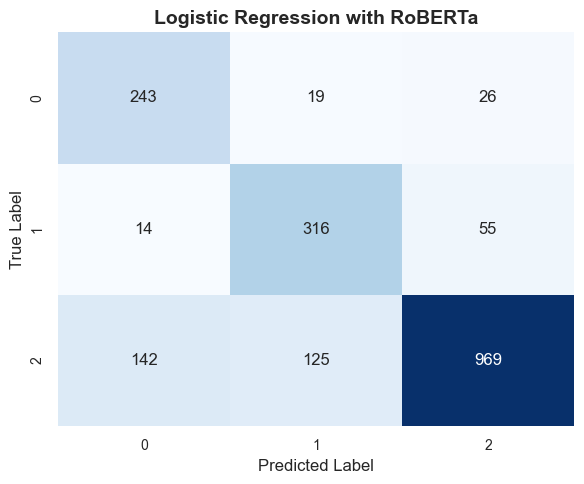

In [149]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, y_val_pred_roberta, title=title, labels=[0, 1, 2], cmap="Blues")

<div class="alert alert-block alert-success">

# **6.** **XGBoost**

<div>

## **6.1** Bag of Words

### **6.1.1** Unigrams

In [150]:
model_xgb =  XGBClassifier(
    objective=objective, 
    num_class=num_class, 
    eval_metric=eval_metric, 
    learning_rate=0.8, 
    max_depth=max_depth_xgboost, 
    n_estimators=n_estimators, 
    subsample=subsample, 
    colsample_bytree=colsample_bytree,
    scale_pos_weight=scale_pos_weight
)

# each term is marked as present or not per document - good for short text
X_bow_unigrams, y_train_pred_bow_unigrams, y_val_pred_bow_unigrams, bow_unigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, model=model_xgb)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:10:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


In [151]:
title = "XGB BoW Unigrams"

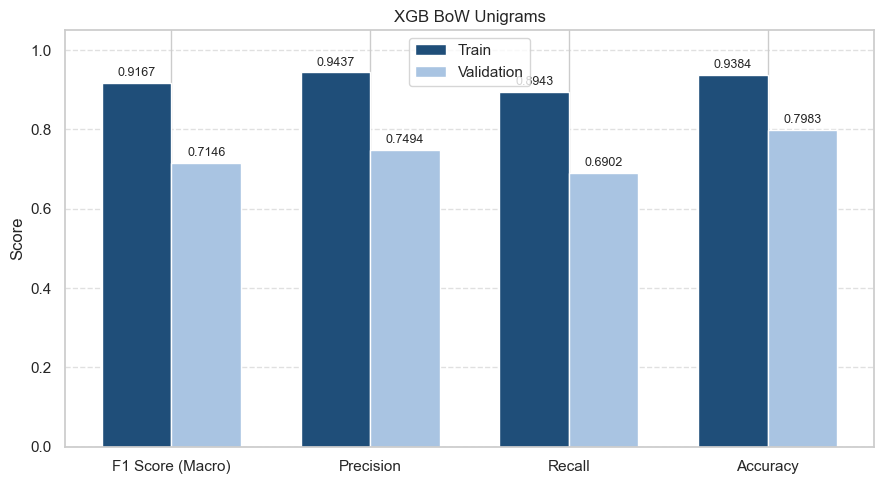

In [152]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_bow_unigrams, y_val, y_val_pred_bow_unigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_bow_unigrams, y_val, y_val_pred_bow_unigrams, title=title)

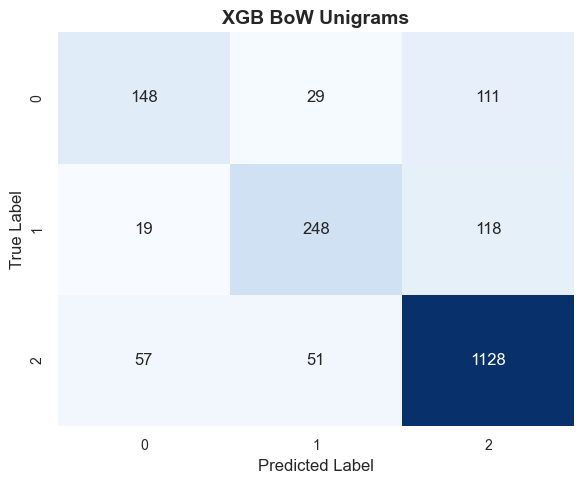

In [153]:
plot_confusion_matrix(y_val, y_val_pred_bow_unigrams, title=title, labels=[0, 1, 2], cmap="Blues")

### **6.1.2** Unigrams + Bigrams

In [154]:
model_xgb =  XGBClassifier(
    objective=objective, 
    num_class=num_class, 
    eval_metric=eval_metric, 
    use_label_encoder=use_label_encoder, 
    learning_rate=learning_rate, 
    max_depth=max_depth_xgboost, 
    n_estimators=n_estimators_xgboost, 
    subsample=subsample, 
    colsample_bytree=colsample_bytree
)

X_bow_bigrams, y_train_pred_bow_bigrams, y_val_pred_bow_bigrams, bow_bigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, model=model_xgb, ngram_range=(1,2))

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:10:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [155]:
title = "XGB BoW Bigrams"

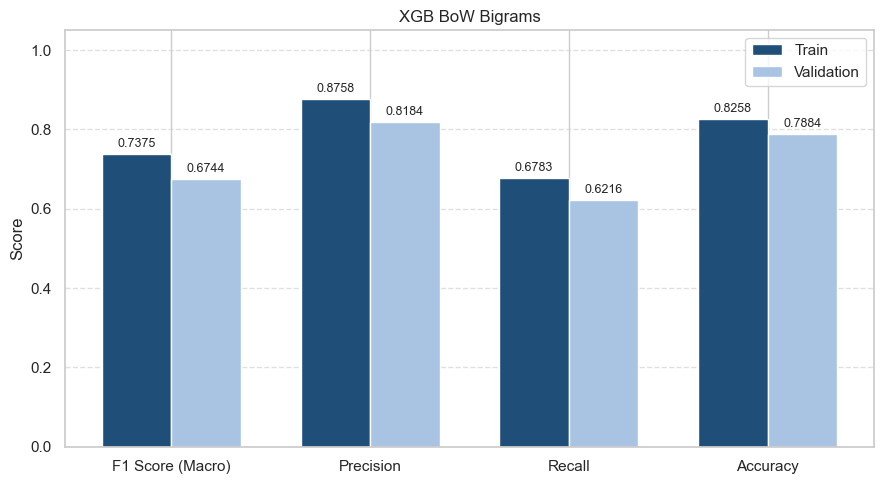

In [156]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_bow_bigrams, y_val, y_val_pred_bow_bigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_bow_bigrams, y_val, y_val_pred_bow_bigrams, title=title)

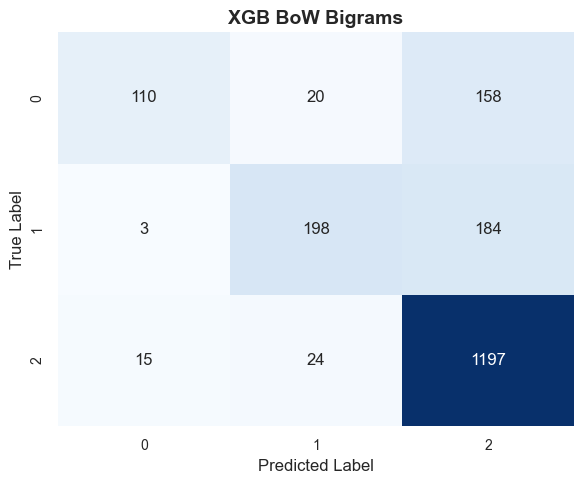

In [157]:
plot_confusion_matrix(y_val, y_val_pred_bow_bigrams, title=title, labels=[0, 1, 2], cmap="Blues")

## **6.2** TF-IDF

### **6.2.1** Unigrams

In [158]:
model_xgb =  XGBClassifier(
    objective=objective, 
    num_class=num_class, 
    eval_metric=eval_metric, 
    use_label_encoder=use_label_encoder, 
    learning_rate=learning_rate, 
    max_depth=max_depth_xgboost, 
    n_estimators=n_estimators_xgboost, 
    subsample=subsample, 
    colsample_bytree=colsample_bytree
)

X_tfidf_unigrams, y_train_pred_tfidf_unigrams, y_val_pred_tfidf_unigrams, tfidf_unigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, model=model_xgb,oversampling_function=oversample)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:10:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [159]:
title = "XGB TF-IDF Unigrams"

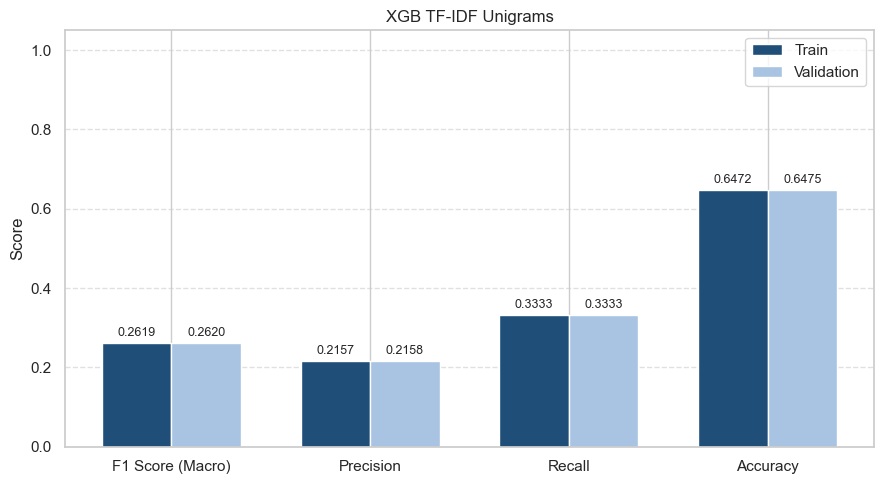

In [160]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_tfidf_unigrams, y_val, y_val_pred_tfidf_unigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_tfidf_unigrams, y_val, y_val_pred_tfidf_unigrams, title=title)

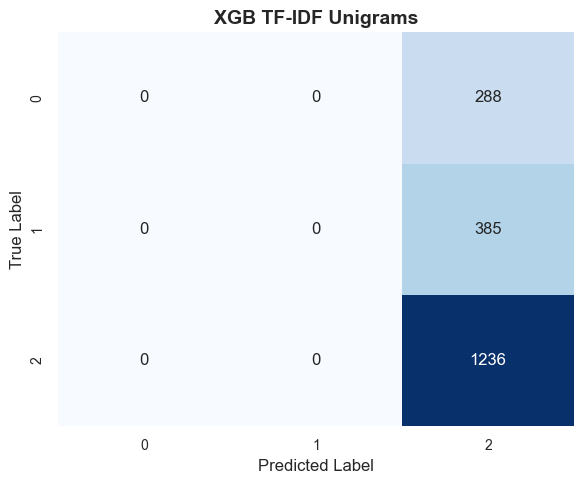

In [161]:
plot_confusion_matrix(y_val, y_val_pred_tfidf_unigrams, title=title, labels=[0, 1, 2], cmap="Blues")

### **6.2.2** Bigrams

In [162]:
model_xgb =  XGBClassifier(
    objective=objective, 
    num_class=num_class, 
    eval_metric=eval_metric, 
    use_label_encoder=use_label_encoder, 
    learning_rate=learning_rate, 
    max_depth=max_depth_xgboost, 
    n_estimators=n_estimators_xgboost, 
    subsample=subsample, 
    colsample_bytree=colsample_bytree
)

X_tfidf_bigrams, y_train_pred_tfidf_bigrams, y_val_pred_tfidf_bigrams, tfidf_bigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, model=model_xgb, ngram_range=(1,2))

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:14:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [163]:
title = "XGB TF-IDF Bigrams"

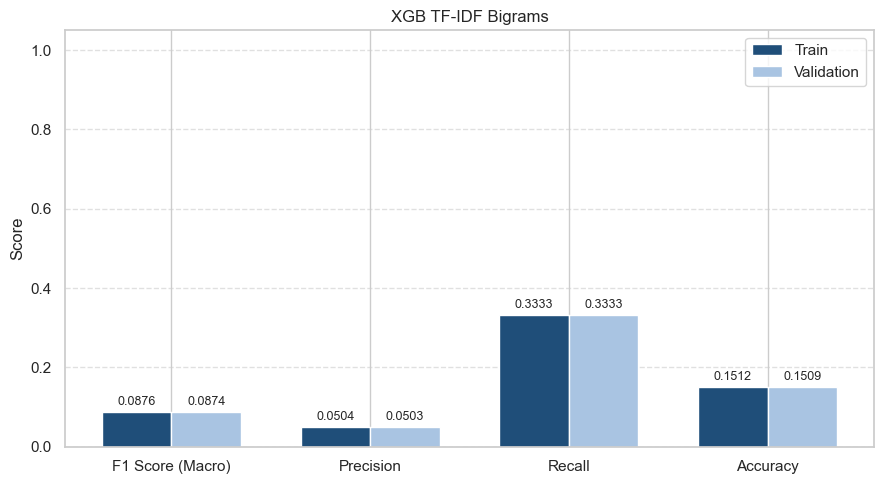

In [164]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_tfidf_bigrams, y_val, y_val_pred_tfidf_bigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_tfidf_bigrams, y_val, y_val_pred_tfidf_bigrams, title=title)

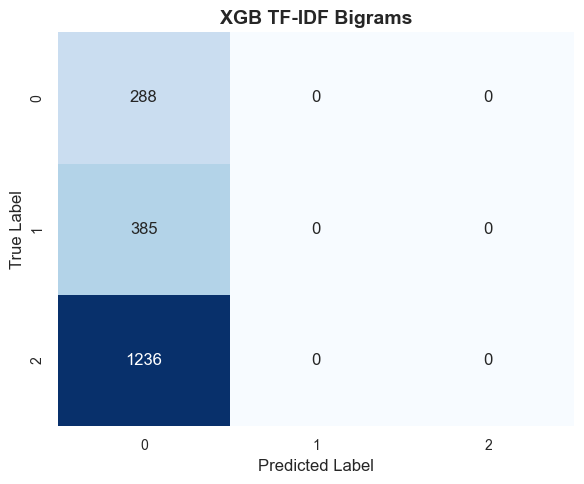

In [165]:
plot_confusion_matrix(y_val, y_val_pred_tfidf_bigrams, title=title, labels=[0, 1, 2], cmap="Blues")

## **6.3** Word2Vec

### **6.3.1** Minimum count = 1


In [166]:
model_xgb =  XGBClassifier(
    objective=objective, 
    num_class=num_class, 
    eval_metric=eval_metric, 
    use_label_encoder=use_label_encoder, 
    learning_rate=learning_rate, 
    max_depth=max_depth_xgboost, 
    n_estimators=n_estimators_xgboost, 
    subsample=subsample, 
    colsample_bytree=colsample_bytree
)

X_train_vec, y_train_pred_vec, y_val_pred_vec = embedding_word2vec(x_train=x_train, y_train=y_train, x_val=x_val, window=window, min_count=min_count, model=model_xgb)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:21:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [167]:
title = "XGB Word2Vec"

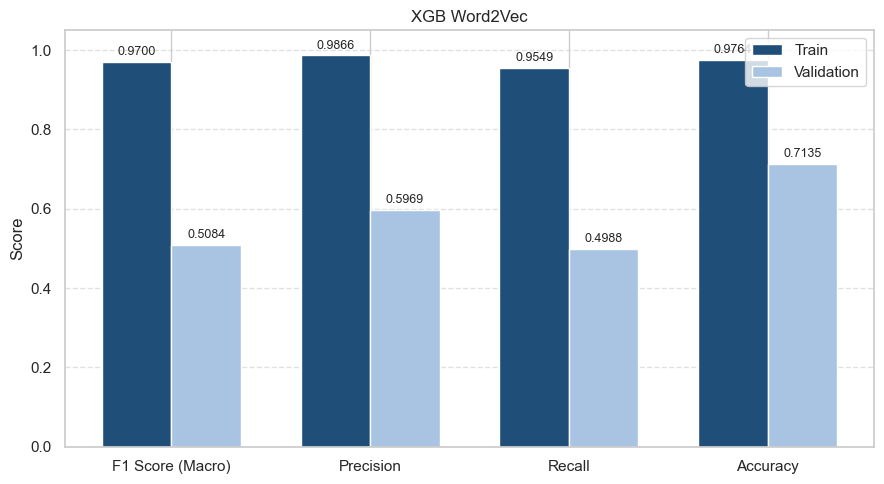

In [168]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_vec, y_val, y_val_pred_vec))

# Plot metrics
plot_metrics(y_train, y_train_pred_vec, y_val, y_val_pred_vec, title=title)

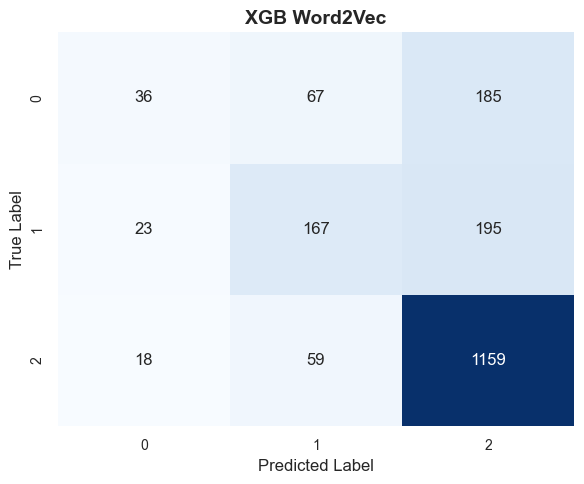

In [169]:
plot_confusion_matrix(y_val, y_val_pred_vec, title=title, labels=[0, 1, 2], cmap="Blues")

### **6.3.2** Minimum count based on percentile

In [170]:
model_xgb =  XGBClassifier(
    objective=objective, 
    num_class=num_class, 
    eval_metric=eval_metric, 
    use_label_encoder=use_label_encoder, 
    learning_rate=learning_rate, 
    max_depth=max_depth_xgboost, 
    n_estimators=n_estimators_xgboost, 
    subsample=subsample, 
    colsample_bytree=colsample_bytree
)

X_train_vec, y_train_pred_vec, y_val_pred_vec = embedding_word2vec(x_train=x_train, y_train=y_train, x_val=x_val, window=window, min_count=percentile_75, model=model_xgb)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:21:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [171]:
title = "XGB Word2Vec - Min count = 75th percentile"

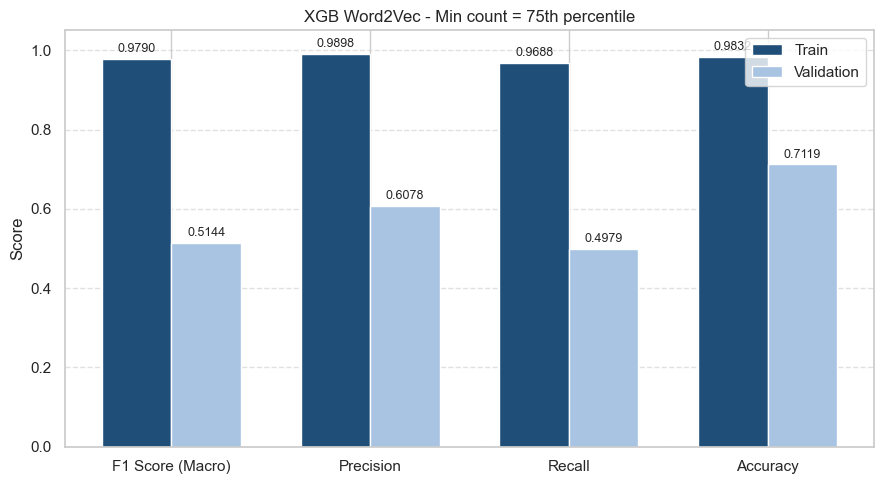

In [172]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_vec, y_val, y_val_pred_vec))

# Plot metrics
plot_metrics(y_train, y_train_pred_vec, y_val, y_val_pred_vec, title=title)

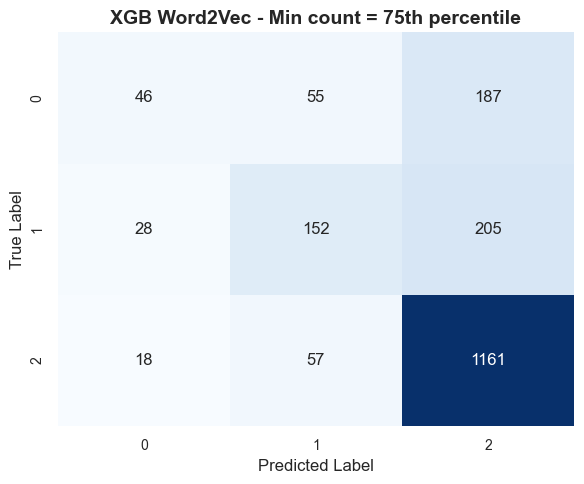

In [173]:
plot_confusion_matrix(y_val, y_val_pred_vec, title=title, labels=[0, 1, 2], cmap="Blues")

## **6.4** Glove

In [174]:
model_xgb =  XGBClassifier(
    objective=objective, 
    num_class=num_class, 
    eval_metric=eval_metric, 
    use_label_encoder=use_label_encoder, 
    learning_rate=learning_rate, 
    max_depth=max_depth_xgboost, 
    n_estimators=n_estimators_xgboost, 
    subsample=subsample, 
    colsample_bytree=colsample_bytree
)

X_train_glove_avg, y_train_pred_glove, y_val_pred_glove = embedding_glove(x_train=x_train, y_train=y_train, x_val=x_val, model_glove = glove_model, emb_size=emb_size, model=model_xgb)

100%|██████████| 1909/1909 [00:00<00:00, 24803.45it/s]
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:22:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [175]:
title = "XGB Glove"

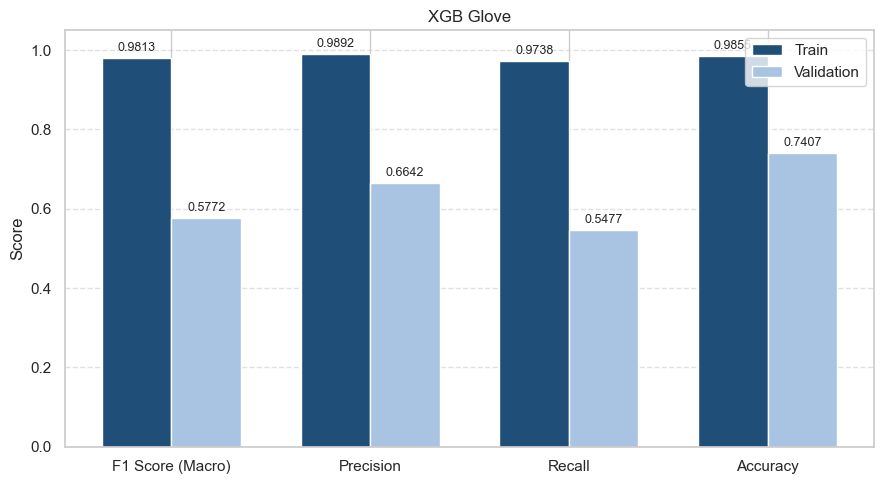

In [176]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_glove, y_val, y_val_pred_glove))

# Plot metrics
plot_metrics(y_train, y_train_pred_glove, y_val, y_val_pred_glove, title=title)

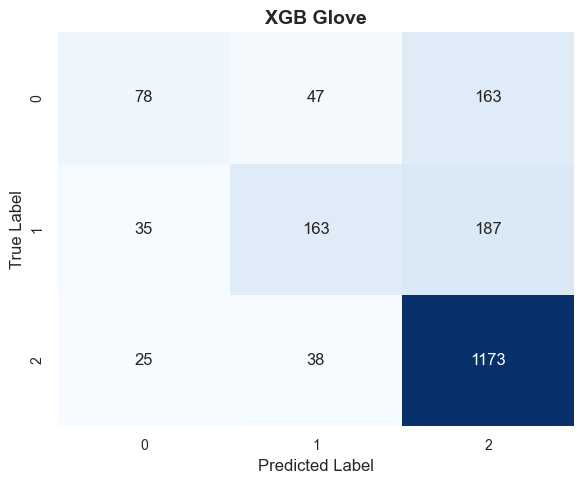

In [177]:
plot_confusion_matrix(y_val, y_val_pred_glove, title=title, labels=[0, 1, 2], cmap="Blues")

## **6.5** Text Embedding 3 Small - EXTRA

In [178]:
model_xgb =  XGBClassifier(
    objective=objective, 
    num_class=num_class, 
    eval_metric=eval_metric, 
    use_label_encoder=use_label_encoder, 
    learning_rate=learning_rate, 
    max_depth=max_depth_xgboost, 
    n_estimators=n_estimators_xgboost, 
    subsample=subsample, 
    colsample_bytree=colsample_bytree
)

X_train_te3s, y_train_pred_te3s,y_val_pred_te3s = embedding_te3s(train_texts=train_texts,
                                                                 train_labels=train_labels,
                                                                 val_texts = val_texts, 
                                                                 cache_file_train="X_train_te3s_embeddings.pkl", 
                                                                 cache_file_val="X_val_te3s_embeddings.pkl",
                                                                 client=client,
                                                                 model_te3s=model_te3s,
                                                                 batch_size=32,
                                                                 model=model_xgb)

Loading embeddings from X_train_te3s_embeddings.pkl...
Loading embeddings from X_val_te3s_embeddings.pkl...


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:22:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [179]:
# Define the title for the metrics and plots
title = "XGB with Text Embedding 3 Small"

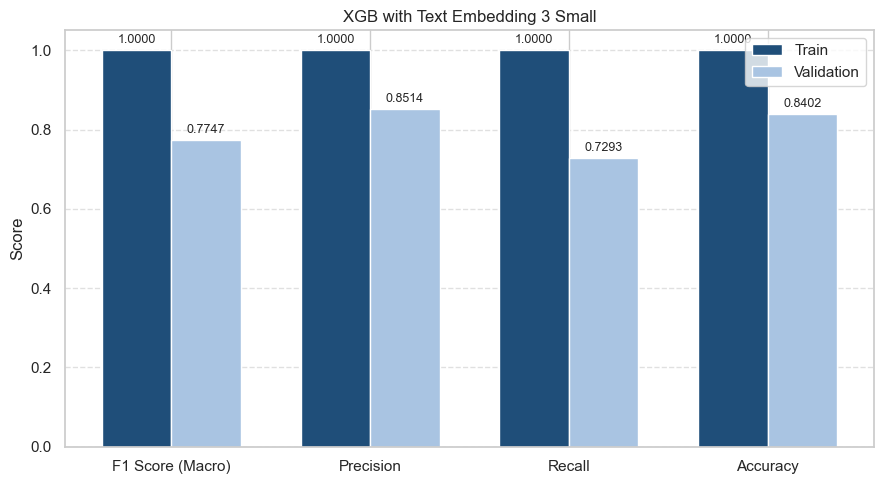

In [180]:
# Get metrics DataFrame
metrics_df.append(get_metrics_df(title, train_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s))
metrics_df

# Plot metrics
plot_metrics(train_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s, title=title)

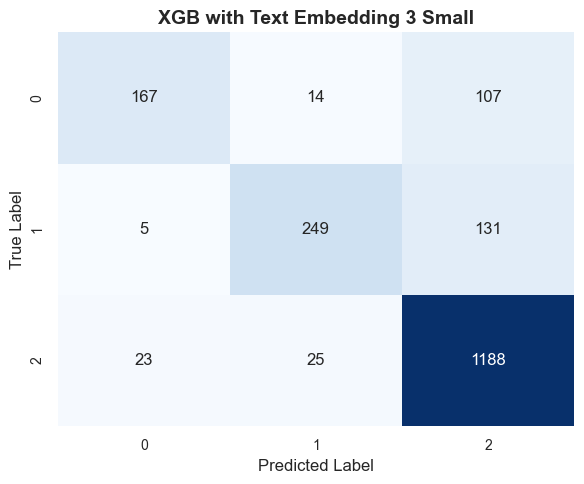

In [181]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, y_val_pred_te3s, title=title, labels=[0, 1, 2], cmap="Blues")

## **6.6** Twitter Roberta Base - EXTRA

In [182]:
model_xgb =  XGBClassifier(
    objective=objective, 
    num_class=num_class, 
    eval_metric=eval_metric, 
    use_label_encoder=use_label_encoder, 
    learning_rate=learning_rate, 
    max_depth=max_depth_xgboost, 
    n_estimators=n_estimators_xgboost, 
    subsample=subsample, 
    colsample_bytree=colsample_bytree
)

X_train_roberta, y_train_pred_roberta,y_val_pred_roberta = embedding_roberta(train_texts=train_texts,
                                                                 train_labels=train_labels,
                                                                 val_texts = val_texts, 
                                                                 cache_file_train="X_train_te3s_embeddings.pkl", 
                                                                 cache_file_val="X_val_te3s_embeddings.pkl",
                                                                 tokenizer_roberta=tokenizer_roberta,
                                                                 model_roberta=model_roberta,
                                                                 batch_size=32,
                                                                 model=modelknn)

Loading RoBERTa embeddings from X_train_te3s_embeddings.pkl...
Loading RoBERTa embeddings from X_val_te3s_embeddings.pkl...


In [183]:
# Define the title for the metrics and plots
title = "XGB with RoBERTa"

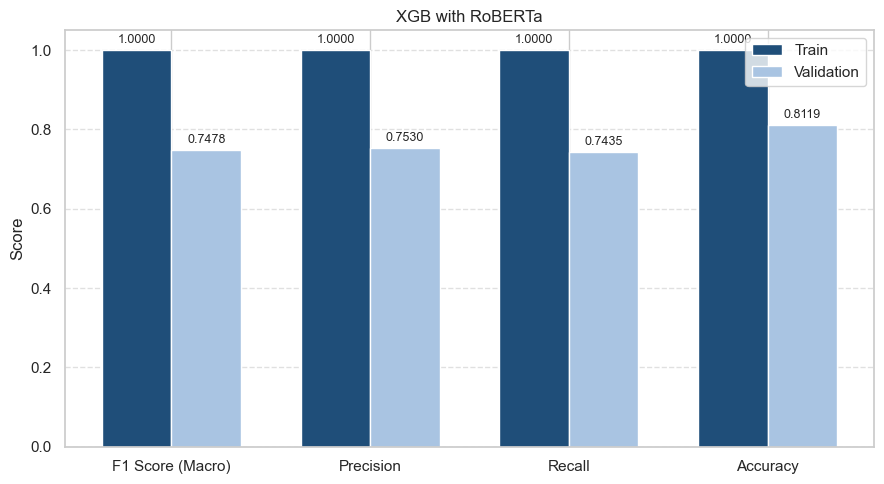

In [184]:
# Get metrics DataFrame
metrics_df.append(get_metrics_df(title, train_labels, y_train_pred_roberta, val_labels, y_val_pred_roberta))
metrics_df

# Plot metrics
plot_metrics(train_labels, y_train_pred_roberta, val_labels, y_val_pred_roberta, title=title)

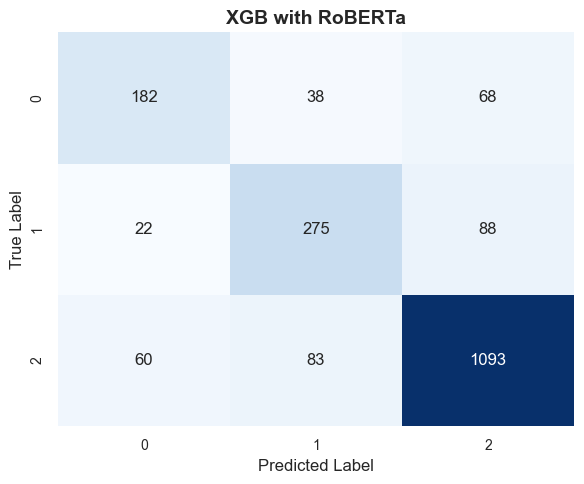

In [185]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, y_val_pred_roberta, title=title, labels=[0, 1, 2], cmap="Blues")

<div class="alert alert-block alert-success">

# **7.** **LSTM**

<div>

BoW and TF-IDF are not suitable for LSTM due to lack of sequential structure

## **7.1** Word2Vec

In [210]:
model_lstm = Model(inputs=input_, outputs=output)
model_lstm.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

X_train_vec, y_train_pred_vec, y_val_pred_vec = embedding_word2vec_lstm(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, window=window, n_classes=num_class, batch_size=batch_size, epochs=epochs, model_lstm=model_lstm, min_count=min_count)

Epoch 1/10


ValueError: Input 0 of layer "functional_7" is incompatible with the layer: expected shape=(None, 26, 50), found shape=(16, 30, 266)

In [203]:
title = "LSTM Word2Vec"

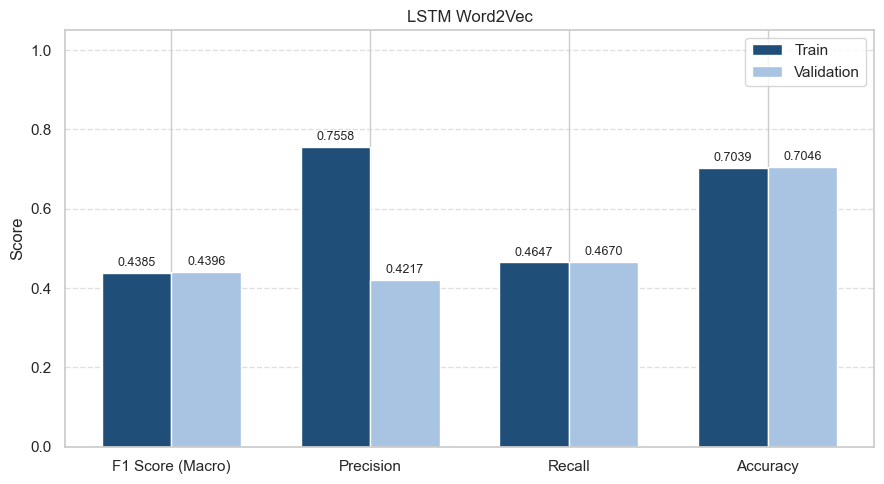

In [194]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_vec, y_val, y_val_pred_vec))

# Plot metrics
plot_metrics(y_train, y_train_pred_vec, y_val, y_val_pred_vec, title=title)

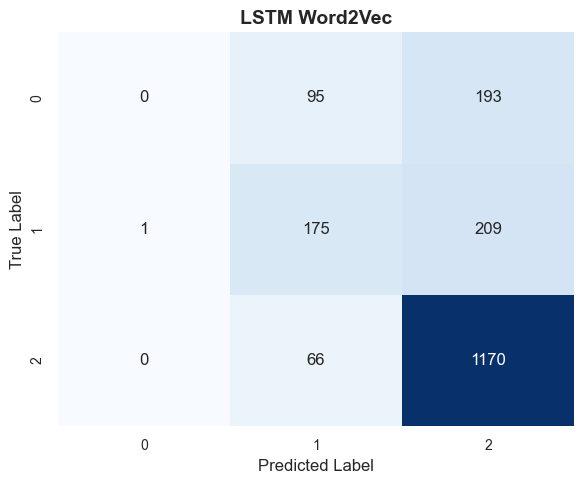

In [195]:
plot_confusion_matrix(y_val, y_val_pred_vec, title=title, labels=[0, 1, 2], cmap="Blues")

## **7.2** Glove

In [211]:
input_ = Input(shape=(26, 50))
x = Masking(mask_value=0.0)(input_)
x = Bidirectional(LSTM(units=units, return_sequences=False, dropout=dropout, recurrent_dropout=dropout))(x)
x = Dropout(dropout)(x)
output = Dense(num_class, activation='softmax')(x)

In [215]:
def embedding_glove_lstm(x_train, y_train, x_val, y_val, model_glove, emb_size, model_lstm, n_classes=3, batch_size=16, epochs=10, oversampling_function=None, max_seq_len=None):
    X_train_vec = corpus2vec(x_train['text'], model_glove)
    X_val_vec = corpus2vec(x_val['text'], model_glove)

    if max_seq_len is None:
        max_seq_len = max(len(seq) for seq in X_train_vec)

    if emb_size is None:
        corpus = x_train['text']

        #get list with lenghts of sentences
        train_len = []
        for i in corpus:
            train_len.append(len(i))
        
        emb_size = max(train_len)
    
    # pad sequences (shape: n_samples x max_seq_len x emb_size)
    X_train_pad = pad_sequences(X_train_vec, maxlen=max_seq_len, dtype='float32', padding='post')
    X_val_pad   = pad_sequences(X_val_vec, maxlen=max_seq_len, dtype='float32', padding='post')

    if oversampling_function:
        X_train_pad, y_train = oversampling_function(X_train_pad, y_train)

    # one-hot encode targets 
    y_train_encoded = tf.one_hot(y_train, depth=n_classes)
    y_val_encoded = tf.one_hot(y_val, depth=n_classes)

    model_lstm.fit(X_train_pad, y_train_encoded, batch_size=batch_size, epochs=epochs, validation_data=(X_val_pad, y_val_encoded))

    y_train_pred = np.argmax(model_lstm.predict(X_train_pad), axis=1)
    y_val_pred = np.argmax(model_lstm.predict(X_val_pad), axis=1)

    return X_train_pad, y_train_pred, y_val_pred


In [216]:
model_lstm = Model(inputs=input_, outputs=output)
model_lstm.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

X_train_glove, y_train_pred_glove, y_val_pred_glove = embedding_glove_lstm(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, model_glove = glove_model, n_classes=num_class, batch_size=batch_size, epochs=epochs, emb_size=emb_size, model_lstm=model_lstm)

100%|██████████| 1909/1909 [00:00<00:00, 23917.55it/s]


Epoch 1/10


ValueError: Unknown variable: <Variable path=bidirectional_5/forward_lstm_5/lstm_cell/kernel, shape=(50, 256), dtype=float32, value=[[-0.01096052  0.09964839  0.13357602 ... -0.12662216  0.00630024
  -0.10398974]
 [-0.08914414  0.06756169 -0.08006575 ...  0.13973449  0.10635315
  -0.08164611]
 [-0.09438086 -0.125642   -0.05257621 ...  0.11202811 -0.01458897
  -0.11289353]
 ...
 [ 0.07463066 -0.11381362 -0.07467085 ... -0.02911093  0.09224346
  -0.05112895]
 [-0.13424893  0.08193803 -0.0585435  ...  0.02088466  0.11275648
   0.04824109]
 [-0.04673175 -0.09257014  0.02960777 ...  0.06365053 -0.074507
   0.03676517]]>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.

In [ ]:
title = "LSTM Glove"

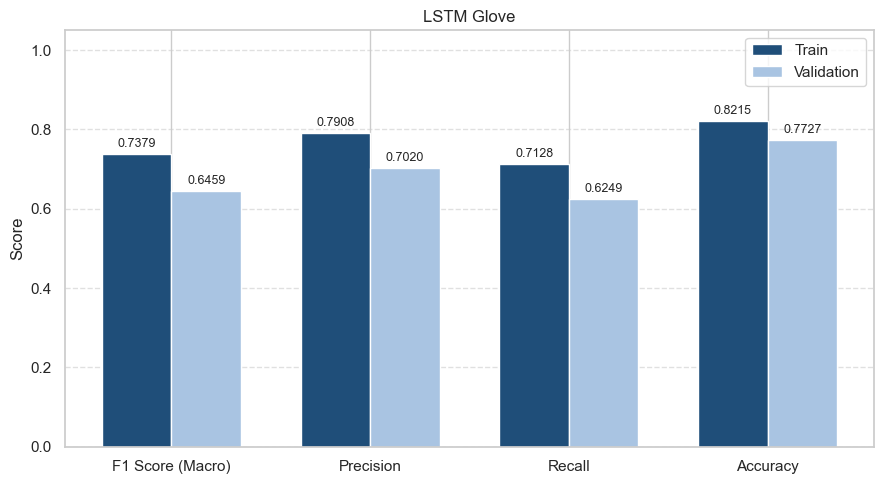

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_glove, y_val, y_val_pred_glove))

# Plot metrics
plot_metrics(y_train, y_train_pred_glove, y_val, y_val_pred_glove, title=title)

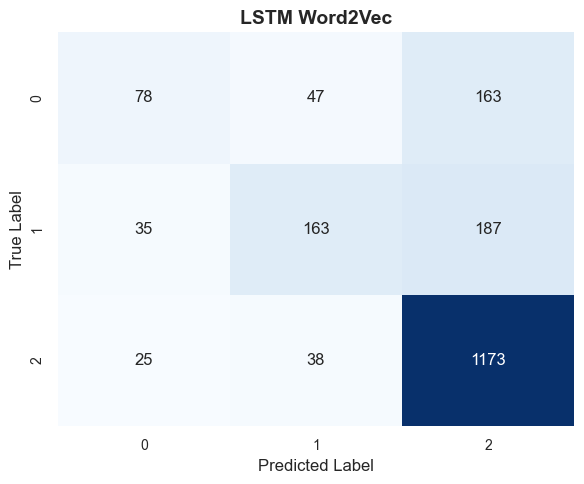

In [199]:
plot_confusion_matrix(y_val, y_val_pred_glove, title=title, labels=[0, 1, 2], cmap="Blues")

<div class="alert alert-block alert-success">

# **9.** **Comparison**

<div>

In [ ]:
import plotly.express as px

fig = px.box(
    metrics_df,
    x="Model",
    y="F1",
    color="Embedding",
    title="F1-Score per Model and Embedding",
    template="plotly_white"
)
fig.update_layout(
    yaxis_title="F1-Score",
    xaxis_title="Model",
    boxmode='group',
    font=dict(size=14)
)
fig.show()


In [218]:
metrics_df = pd.concat(metrics_df, ignore_index=True)

In [220]:
metrics_df.to_csv('metrics_df.csv')